#  Dalil: A YOLOv11-Based Makkah Landmark Detection System with ALLaM-Powered Religious Tourism Interpretation

In [1]:
!pip install roboflow ultralytics matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127

In [2]:
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:

from roboflow import Roboflow
rf = Roboflow(api_key="d01bSv82KRoPdMId2VdT")
project = rf.workspace("cv-mm5i3").project("makkah-landmarkd-wgpc6")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Makkah-Landmarkd-1 in yolov11:: 100%|██████████| 1073/1073 [00:00<00:00, 1942.39it/s]


# EDA

In [4]:
import os
import cv2
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

image_dir = "/content/Makkah-Landmarkd-1/train/images"
label_dir = "/content/Makkah-Landmarkd-1/train/labels"

class_names = [
    'AlSafa-and-Marwah-Mountain',
    'Blackstone',
    'ClockTower',
    'Jamarat',
    'Kaaba',
    'Maqam-Ibrahim',
    'YemeniCorner'
]

image_shapes = []
class_counter = Counter()
objects_per_image = []

missing_labels = 0
empty_labels = 0
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files):
    img_path = os.path.join(image_dir, img_name)
    lbl_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

    image = cv2.imread(img_path)
    if image is not None:
        h, w = image.shape[:2]
        image_shapes.append((w, h))

    if not os.path.exists(lbl_path):
        missing_labels += 1
        continue

    with open(lbl_path, "r") as f:
        lines = f.readlines()
        if not lines:
            empty_labels += 1
        objects_per_image.append(len(lines))
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(parts[0])
                class_counter[cls_id] += 1




100%|██████████| 513/513 [00:02<00:00, 211.43it/s]


In [5]:
image_size_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
class_dist_df = pd.DataFrame.from_dict(
    {class_names[k]: v for k, v in class_counter.items()},
    orient='index', columns=['Count']
).sort_values(by='Count', ascending=False)

print("\n✅ Dataset Summary:")
print(f"Total images      : {len(image_files)}")
print(f"Missing labels    : {missing_labels}")
print(f"Empty label files : {empty_labels}")
print(f"Avg objects/image : {sum(objects_per_image)/len(objects_per_image):.2f}")

print("\n📐 Image Size Distribution:")
print(image_size_df.describe())

print("\n📌 Class Distribution:")
print(class_dist_df)




✅ Dataset Summary:
Total images      : 513
Missing labels    : 0
Empty label files : 0
Avg objects/image : 1.22

📐 Image Size Distribution:
       Width  Height
count  513.0   513.0
mean   640.0   640.0
std      0.0     0.0
min    640.0   640.0
25%    640.0   640.0
50%    640.0   640.0
75%    640.0   640.0
max    640.0   640.0

📌 Class Distribution:
                            Count
Kaaba                         183
ClockTower                    108
Blackstone                     93
Maqam-Ibrahim                  84
Jamarat                        57
YemeniCorner                   51
AlSafa-and-Marwah-Mountain     48


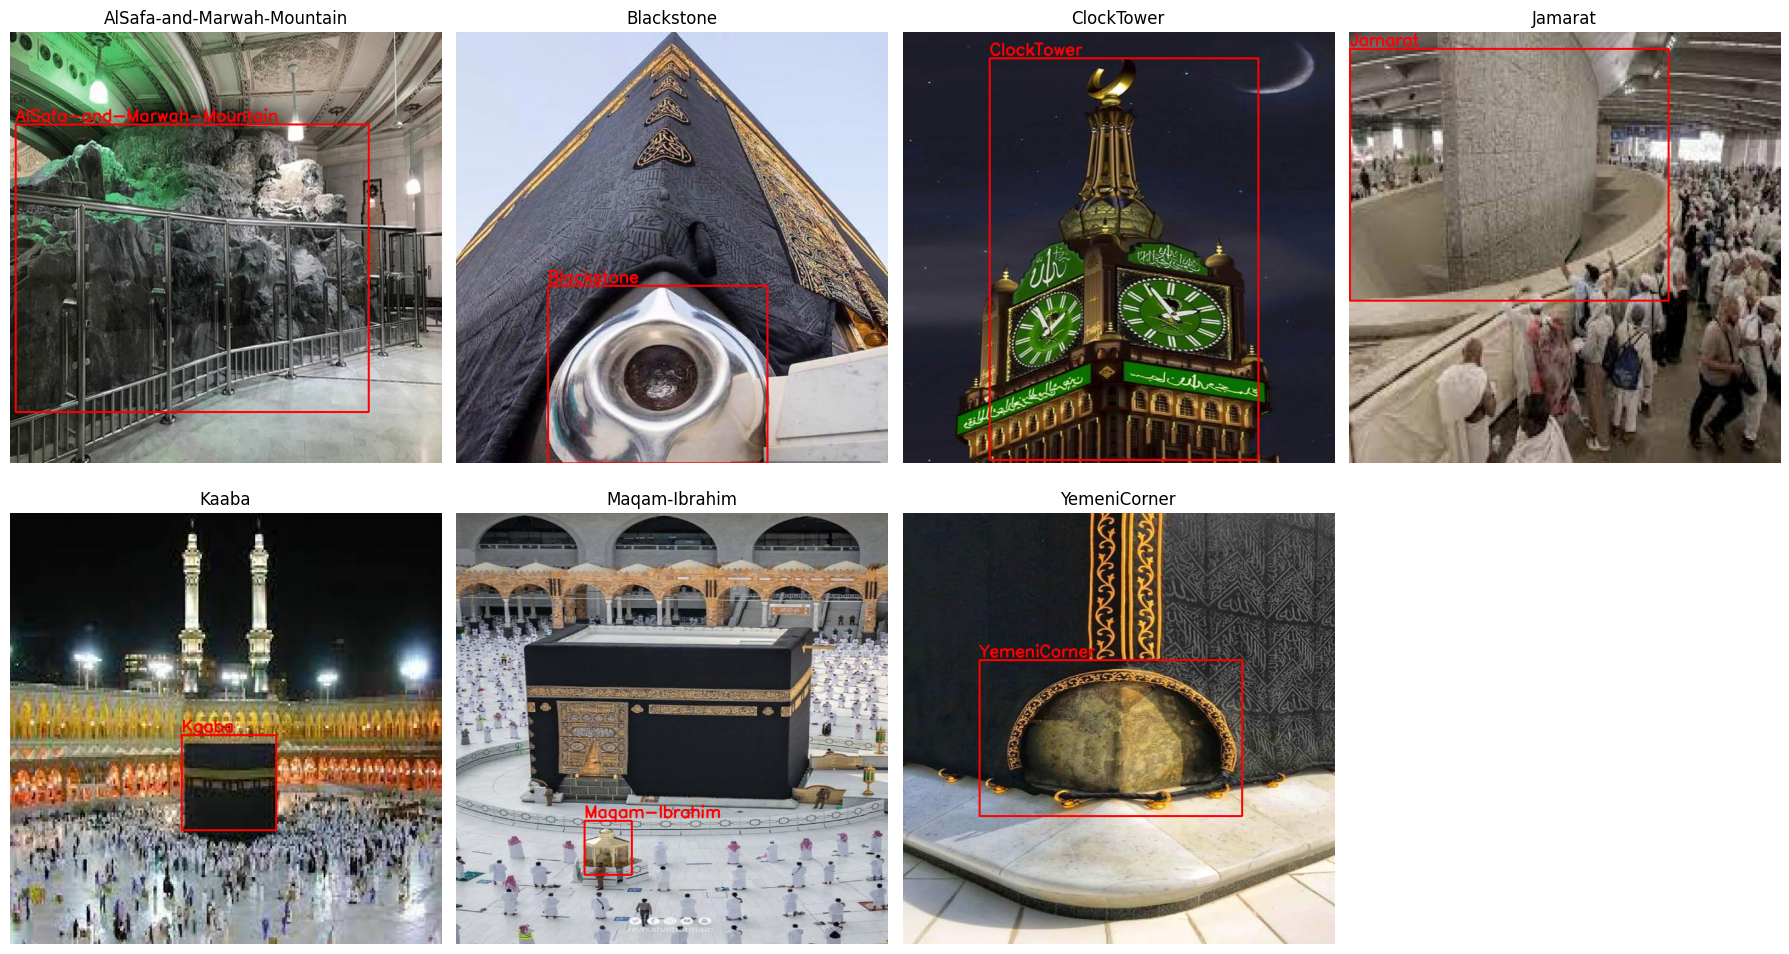

In [6]:


found_samples = {}

for img_file in os.listdir(image_dir):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file)
    img_path = os.path.join(image_dir, img_file)

    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                if class_id not in found_samples:
                    found_samples[class_id] = (img_path, label_path)
            if len(found_samples) == len(class_names):
                break
    if len(found_samples) == len(class_names):
        break

plt.figure(figsize=(18, 10))
for cls_id, (img_path, label_path) in found_samples.items():
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                c, x, y, bw, bh = map(float, parts)
                if int(c) != cls_id:
                    continue
                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, class_names[int(c)], (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    plt.subplot(2, 4, cls_id + 1)
    plt.imshow(img)
    plt.title(class_names[cls_id])
    plt.axis('off')

plt.tight_layout()
plt.show()


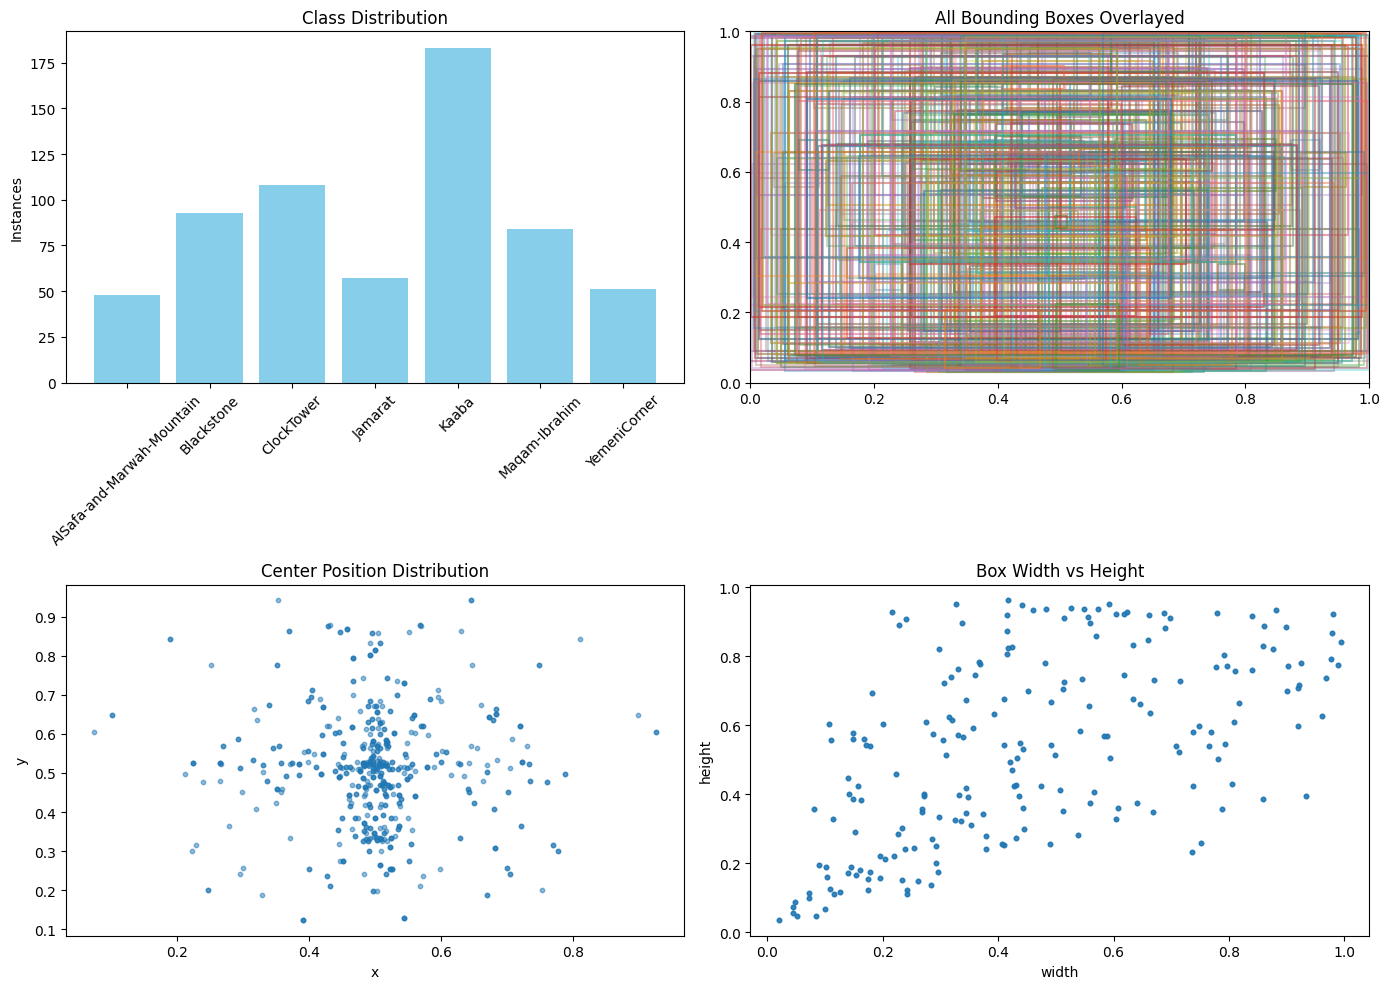

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Store values
data = {'class': [], 'x': [], 'y': [], 'w': [], 'h': []}

# Read all labels
for label_file in os.listdir(label_dir):
    if not label_file.endswith(".txt"):
        continue
    with open(os.path.join(label_dir, label_file), 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                c, x, y, w, h = map(float, parts)
                data['class'].append(int(c))
                data['x'].append(x)
                data['y'].append(y)
                data['w'].append(w)
                data['h'].append(h)

df = pd.DataFrame(data)

# Create the 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 📊 Top-left: class distribution
class_counts = df['class'].value_counts().sort_index()
axs[0, 0].bar([class_names[i] for i in class_counts.index], class_counts.values, color='skyblue')
axs[0, 0].set_title("Class Distribution")
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].set_ylabel("Instances")

# 📐 Top-right: all boxes overlayed
for i in range(len(df)):
    x1 = df['x'][i] - df['w'][i] / 2
    y1 = df['y'][i] - df['h'][i] / 2
    x2 = df['x'][i] + df['w'][i] / 2
    y2 = df['y'][i] + df['h'][i] / 2
    axs[0, 1].plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], alpha=0.3)
axs[0, 1].set_title("All Bounding Boxes Overlayed")
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_ylim(0, 1)

# 🔵 Bottom-left: center x vs y
axs[1, 0].scatter(df['x'], df['y'], alpha=0.5, s=10)
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_title("Center Position Distribution")

# 🔶 Bottom-right: width vs height
axs[1, 1].scatter(df['w'], df['h'], alpha=0.5, s=10)
axs[1, 1].set_xlabel("width")
axs[1, 1].set_ylabel("height")
axs[1, 1].set_title("Box Width vs Height")

plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

label_dir = "/content/Makkah-Landmarkd-1/train/labels"
class_names = [
    'AlSafa-and-Marwah-Mountain',
    'Blackstone',
    'ClockTower',
    'Jamarat',
    'Kaaba',
    'Maqam-Ibrahim',
    'YemeniCorner'
]

data = {'class': [], 'x': [], 'y': [], 'w': [], 'h': []}

for label_file in os.listdir(label_dir):
    if not label_file.endswith(".txt"):
        continue
    with open(os.path.join(label_dir, label_file), 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                c, x, y, w, h = map(float, parts)
                data['class'].append(int(c))
                data['x'].append(x)
                data['y'].append(y)
                data['w'].append(w)
                data['h'].append(h)

# Create the dataframe
df = pd.DataFrame(data)



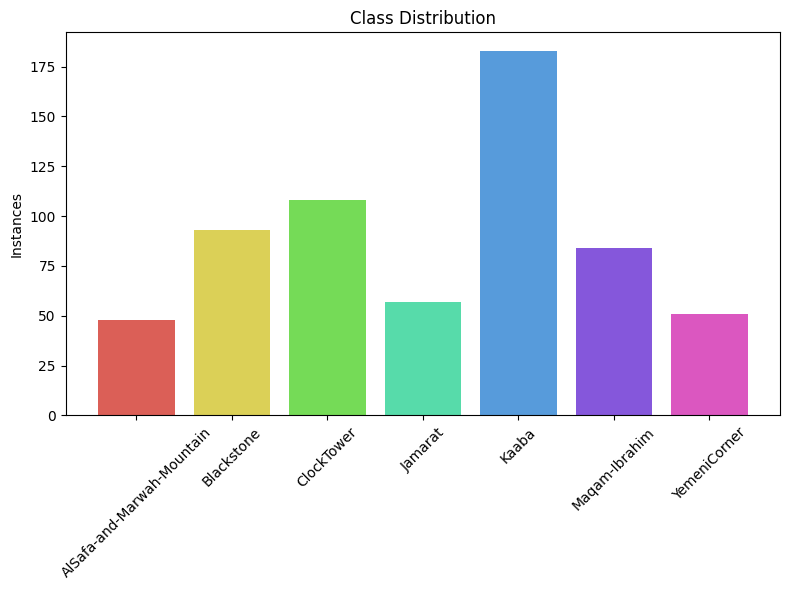

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
palette = sns.color_palette("hls", len(class_names))

class_counts = df['class'].value_counts().sort_index()
labels = [class_names[i] for i in class_counts.index]
values = class_counts.values

bars = plt.bar(labels, values, color=palette)
plt.title("Class Distribution")
plt.ylabel("Instances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



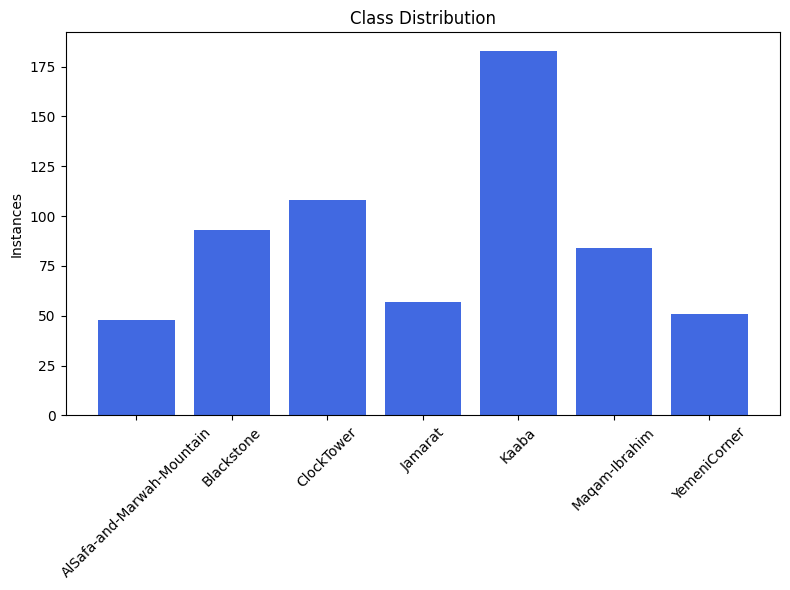

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

class_counts = df['class'].value_counts().sort_index()
labels = [class_names[i] for i in class_counts.index]
values = class_counts.values

bars = plt.bar(labels, values, color='royalblue')

plt.title("Class Distribution")
plt.ylabel("Instances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


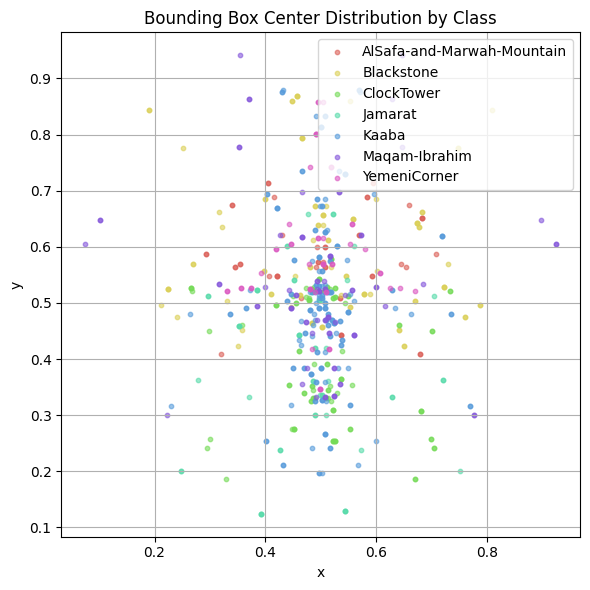

In [11]:
plt.figure(figsize=(6, 6))
palette = sns.color_palette("hls", len(class_names))
for cls_id in sorted(df['class'].unique()):
    class_data = df[df['class'] == cls_id]
    plt.scatter(class_data['x'], class_data['y'], s=10, alpha=0.6, label=class_names[cls_id], color=palette[cls_id])

plt.title("Bounding Box Center Distribution by Class")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


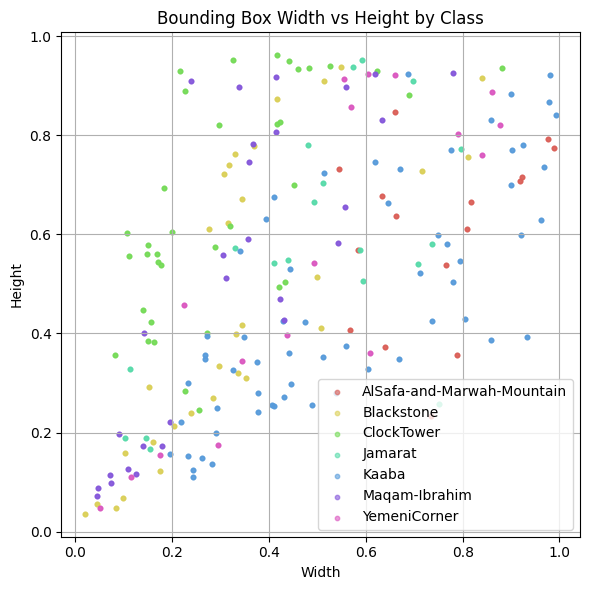

In [12]:
plt.figure(figsize=(6, 6))
for cls_id in sorted(df['class'].unique()):
    class_data = df[df['class'] == cls_id]
    plt.scatter(class_data['w'], class_data['h'], s=10, alpha=0.6, label=class_names[cls_id], color=palette[cls_id])

plt.title("Bounding Box Width vs Height by Class")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


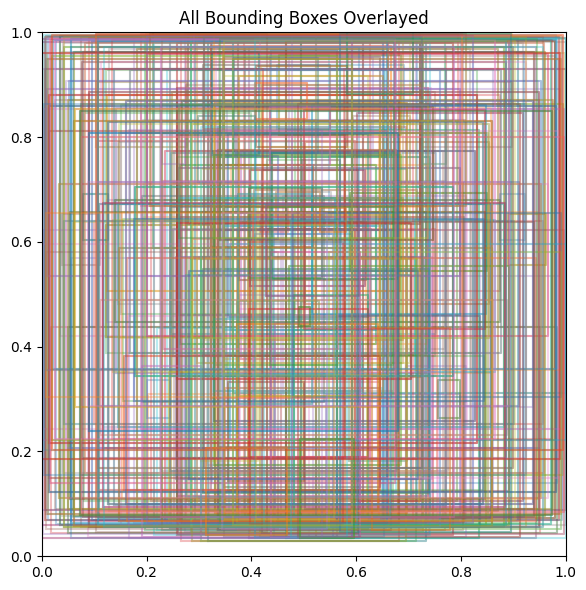

In [13]:
#  All Bounding Boxes Overlayed
plt.figure(figsize=(6, 6))
for i in range(len(df)):
    x1 = df['x'][i] - df['w'][i] / 2
    y1 = df['y'][i] - df['h'][i] / 2
    x2 = df['x'][i] + df['w'][i] / 2
    y2 = df['y'][i] + df['h'][i] / 2
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], alpha=0.3)
plt.title("All Bounding Boxes Overlayed")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


# Preprocessing

In [14]:
import os
import shutil
from collections import Counter

source_img_dir = "/content/Makkah-Landmarkd-1/train/images"
source_lbl_dir = "/content/Makkah-Landmarkd-1/train/labels"

target_count = 100
duplication_counts = Counter()

class_counts = Counter()
file_map = {}

for label_file in os.listdir(source_lbl_dir):
    if not label_file.endswith(".txt"):
        continue
    path = os.path.join(source_lbl_dir, label_file)
    with open(path, 'r') as f:
        lines = f.readlines()
        classes_in_file = [int(line.split()[0]) for line in lines]
        file_map[label_file] = classes_in_file
        for cls in classes_in_file:
            class_counts[cls] += 1

for cls_id in [0, 3, 6]:
    needed = target_count - class_counts[cls_id]
    if needed <= 0:
        continue

    print(f"📈 Duplicating class {cls_id} - need {needed} more samples")
    dup = 0

    for label_file, classes in file_map.items():
        if cls_id not in classes:
            continue

        base = os.path.splitext(label_file)[0]
        img_path = os.path.join(source_img_dir, base + ".jpg")
        lbl_path = os.path.join(source_lbl_dir, base + ".txt")

        if not os.path.exists(img_path):
            continue

        for i in range(3):
            new_base = f"{base}_dup{cls_id}_{i}"
            new_img = os.path.join(source_img_dir, new_base + ".jpg")
            new_lbl = os.path.join(source_lbl_dir, new_base + ".txt")

            if not os.path.exists(new_img):
                shutil.copy(img_path, new_img)
                shutil.copy(lbl_path, new_lbl)
                duplication_counts[cls_id] += 1
                dup += 1

            if duplication_counts[cls_id] >= needed:
                break

        if duplication_counts[cls_id] >= needed:
            break

print("✅ Duplication complete.")


📈 Duplicating class 0 - need 52 more samples
📈 Duplicating class 3 - need 43 more samples
📈 Duplicating class 6 - need 49 more samples
✅ Duplication complete.


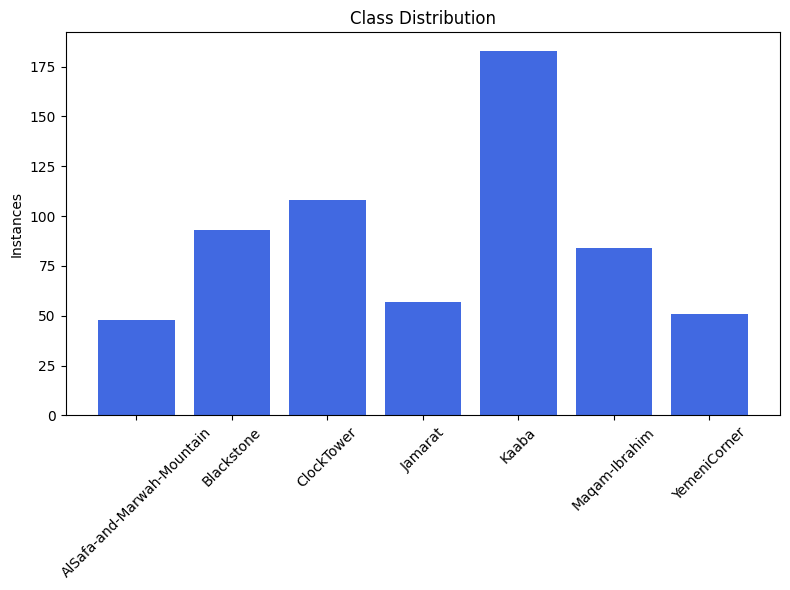

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

class_counts = df['class'].value_counts().sort_index()
labels = [class_names[i] for i in class_counts.index]
values = class_counts.values

bars = plt.bar(labels, values, color='royalblue')

plt.title("Class Distribution")
plt.ylabel("Instances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import os
from collections import Counter

labels_dir = "/content/Makkah-Landmarkd-1/train/labels"
class_counts = Counter()

for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                cls_id = int(line.strip().split()[0])
                class_counts[cls_id] += 1

print("📊 Class counts (label frequency):")
for cls_id, count in class_counts.items():
    print(f"Class {cls_id}: {count} instances")

📊 Class counts (label frequency):
Class 2: 108 instances
Class 0: 100 instances
Class 4: 189 instances
Class 3: 108 instances
Class 5: 84 instances
Class 6: 100 instances
Class 1: 93 instances


In [17]:
import os
import cv2
import random
import numpy as np
import albumentations as A
from tqdm import tqdm

input_images_dir = "/content/Makkah-Landmarkd-1/train/images"
input_labels_dir = "/content/Makkah-Landmarkd-1/train/labels"
output_images_dir = "/content/drive/MyDrive/Makkah_Enhanced_Preprocessed/images"
output_labels_dir = "/content/drive/MyDrive/Makkah_Enhanced_Preprocessed/labels"
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

transform = A.Compose([
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), p=0.7),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def add_night_effect(image):
    night_filter = np.full(image.shape, (10, 10, 50), dtype=np.uint8)
    return cv2.addWeighted(image, 0.5, night_filter, 0.5, 0)

def add_fog_effect(image, fog_strength=0.4):
    overlay = np.full_like(image, 255, dtype=np.uint8)
    return cv2.addWeighted(image, 1 - fog_strength, overlay, fog_strength, 0)

def add_sun_glare(image):
    h, w = image.shape[:2]
    cx = random.randint(int(w * 0.3), int(w * 0.7))
    cy = random.randint(int(h * 0.1), int(h * 0.3))
    radius = random.randint(80, 150)
    overlay = image.copy()
    cv2.circle(overlay, (cx, cy), radius, (255, 255, 255), -1)
    return cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

def add_dust_effect(image, num_particles=250):
    h, w = image.shape[:2]
    overlay = image.copy()
    for _ in range(num_particles):
        x = random.randint(0, w-1)
        y = random.randint(0, h-1)
        r = random.randint(1, 3)
        color = (random.randint(180, 210), random.randint(180, 210), random.randint(150, 180))
        cv2.circle(overlay, (x, y), r, color, -1)
    return cv2.addWeighted(image, 0.96, overlay, 0.04, 0)

effects = [add_night_effect, add_fog_effect, add_sun_glare, add_dust_effect]

def read_yolo_labels(label_path):
    bboxes, class_labels = [], []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls, x, y, w, h = map(float, parts)
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))
    return bboxes, class_labels

def save_yolo_labels(label_out_path, bboxes, class_labels):
    with open(label_out_path, 'w') as f:
        for box, cls in zip(bboxes, class_labels):
            f.write(f"{cls} {' '.join(map(str, box))}\n")

for image_name in tqdm(os.listdir(input_images_dir)):
    if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    image_path = os.path.join(input_images_dir, image_name)
    label_path = os.path.join(input_labels_dir, os.path.splitext(image_name)[0] + ".txt")

    if not os.path.exists(label_path):
        print(f"⚠️ Missing label for {image_name}, skipping...")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Skipping unreadable image: {image_name}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes, class_labels = read_yolo_labels(label_path)
    if not bboxes:
        continue

    try:
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_classes = augmented['class_labels']
    except Exception as e:
        print(f"❌ Augmentation error for {image_name}: {e}")
        continue

    if random.random() < 0.1:
        chosen_effect = random.choice(effects)
        aug_image = chosen_effect(aug_image)

    if aug_bboxes:
        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_images_dir, image_name), aug_image_bgr)
        save_yolo_labels(os.path.join(output_labels_dir, os.path.splitext(image_name)[0] + ".txt"), aug_bboxes, aug_classes)

print("✅ Preprocessing complete: precision-focused with realistic variation.")


100%|██████████| 657/657 [00:07<00:00, 90.14it/s]

✅ Preprocessing complete: precision-focused with realistic variation.


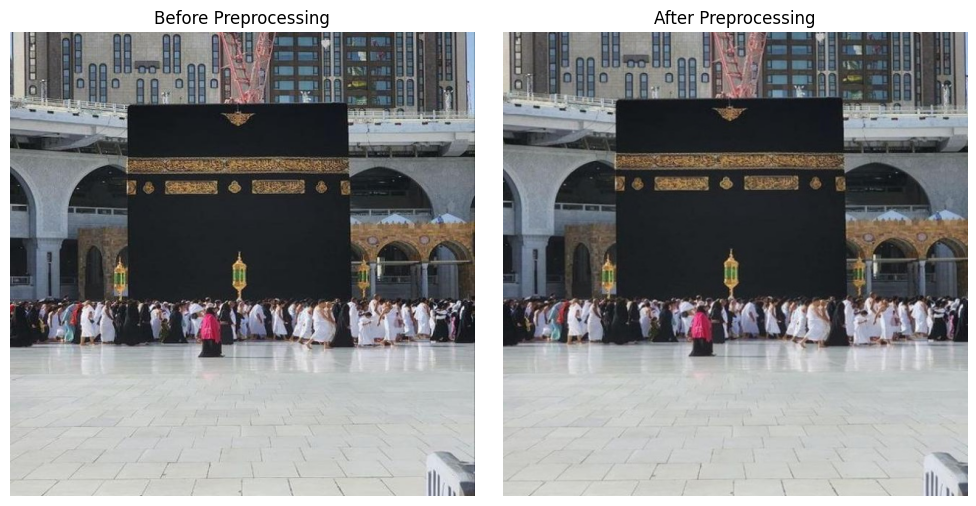

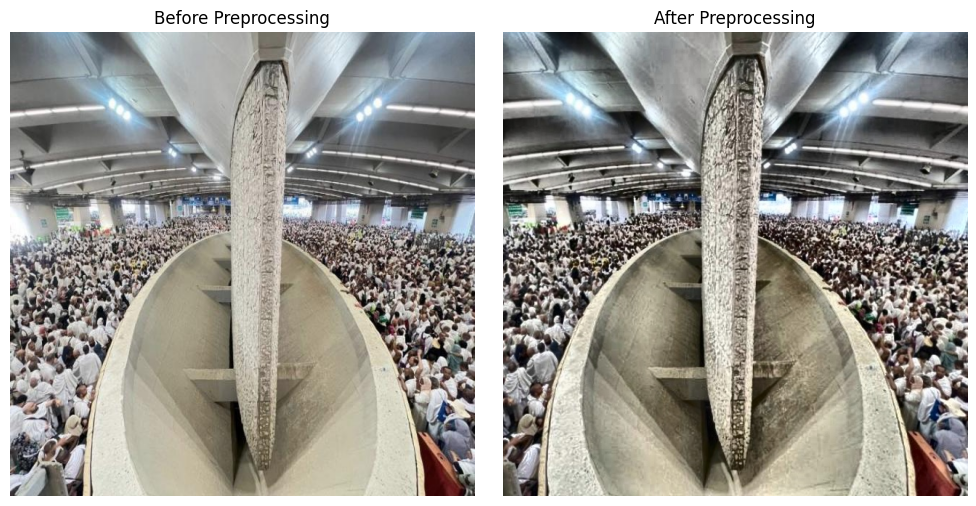

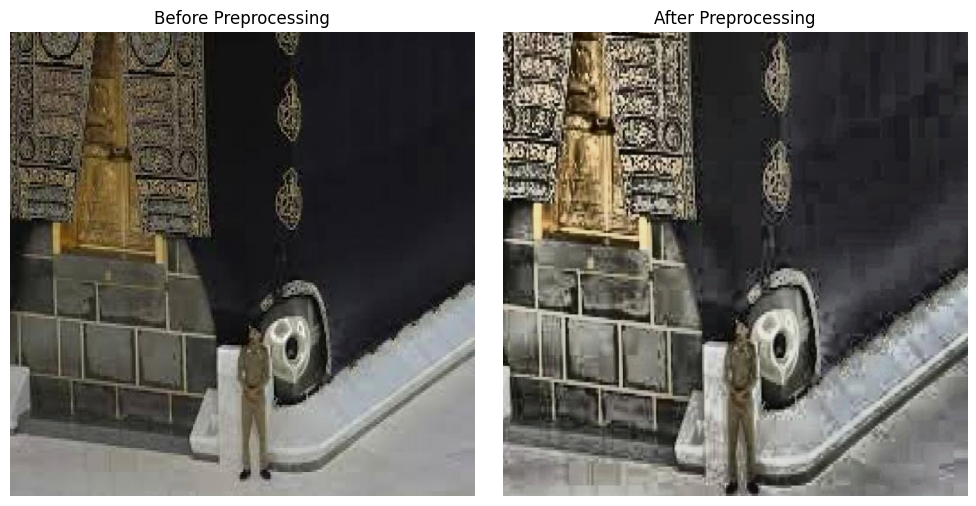

In [18]:
import random

samples_to_visualize = random.sample(os.listdir(input_images_dir), 3)


for image_name in samples_to_visualize:
    if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    original_path = os.path.join(input_images_dir, image_name)
    processed_path = os.path.join(output_images_dir, image_name)

    if not os.path.exists(original_path) or not os.path.exists(processed_path):
        continue

    original = cv2.imread(original_path)
    processed = cv2.imread(processed_path)

    if original is None or processed is None:
        continue

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Before Preprocessing")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(processed)
    plt.title("After Preprocessing")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"/content/before_after_{os.path.splitext(image_name)[0]}.png", dpi=300)
    plt.show()


In [19]:
%%writefile /content/Makkah-Landmarkd-1/data.yaml
train: /content/drive/MyDrive/Makkah_Enhanced_Preprocessed/images
val: /content/Makkah-Landmarkd-1/valid/images

nc: 7
names: ['AlSafa-and-Marwah-Mountain', 'Blackstone', 'ClockTower', 'Jamarat', 'Kaaba', 'Maqam-Ibrahim', 'YemeniCorner']


Overwriting /content/Makkah-Landmarkd-1/data.yaml


yolo11n.pt


#yolo11s.pt



In [20]:
# Load a pretrained YOLOv
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 180MB/s]


In [21]:

results = model.train(
    data=dataset.location + '/data.yaml',
    epochs=800,  # Extended training time
    batch=16,  # Kept moderate for better gradient updates
    name="makkah-yolo",
    optimizer='AdamW',  # AdamW often performs better for fine-tuning
    lr0=0.001,  # Lower starting LR for more precise updates
    lrf=0.0001,  # Very gradual decay
    weight_decay=0.0003,  # Careful regularization
    warmup_epochs=10,  # Extended warmup
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    patience=200,  # Longer patience
    label_smoothing=0.01,  # Modest smoothing
    mosaic=0.15,  # Light augmentation
    mixup=0.1,
    hsv_h=0.015,
    hsv_s=0.15,
    hsv_v=0.15,
    flipud=0.1,  # Added some vertical flips
    fliplr=0.4,  # More horizontal flips
    cos_lr=True,
    verbose=True,
    overlap_mask=True,  # Better instance segmentation if applicable
    single_cls=False,  # Set to True if only one class
    device=0,  # Use CPU for training,
    amp=True,  # Mixed precision for faster training
    close_mosaic=100,  # Disable mosaic in final epochs
    plots=True,  # Generate performance plots
    save=True  # Save checkpoints
)


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Makkah-Landmarkd-1/data.yaml, epochs=800, time=None, patience=200, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=makkah-yolo, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=100, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,591,205 parameters, 2,591,189 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2194.5±993.0 MB/s, size: 130.7 KB)


train: Scanning /content/drive/MyDrive/Makkah_Enhanced_Preprocessed/labels... 657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 657/657 [00:00<00:00, 2430.42it/s]

train: New cache created: /content/drive/MyDrive/Makkah_Enhanced_Preprocessed/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 881.7±537.3 MB/s, size: 65.8 KB)


val: Scanning /content/Makkah-Landmarkd-1/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1809.49it/s]

val: New cache created: /content/Makkah-Landmarkd-1/valid/labels.cache


Plotting labels to runs/detect/makkah-yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0003), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/makkah-yolo
Starting training for 800 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/800      2.29G      1.414      3.611      1.865          1        640: 100%|██████████| 42/42 [00:14<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         19         24    0.00676      0.556     0.0144    0.00319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/800      2.32G      1.338      2.731      1.772          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         19         24     0.0308       0.52     0.0859     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/800      2.33G      1.206      2.123      1.678          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         19         24     0.0357      0.651      0.172      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/800      2.35G      1.208      1.816      1.671          2        640: 100%|██████████| 42/42 [00:13<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         19         24      0.595      0.194      0.386      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/800      2.36G      1.225      1.666      1.671          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19         24        0.9      0.238      0.387      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/800      2.38G      1.232       1.56      1.675          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         19         24      0.695      0.715      0.771      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/800      2.39G       1.22      1.566      1.665          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         19         24      0.665      0.699      0.791      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/800      2.41G      1.204        1.5      1.649          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24        0.4      0.661      0.615       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/800      2.42G      1.214      1.469       1.65          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         19         24      0.683      0.512      0.641      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/800      2.44G      1.191      1.353      1.628          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all         19         24      0.719       0.64      0.689      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/800      2.45G      1.137      1.353      1.583          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.535      0.681      0.629      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/800      2.46G      1.173      1.335      1.618          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24      0.619      0.652      0.741      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/800      2.48G      1.123       1.23      1.547          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         19         24      0.821      0.512      0.753      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/800      2.49G      1.122      1.248      1.557          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all         19         24      0.682      0.707      0.737       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/800      2.51G      1.128      1.213      1.562          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.906      0.691      0.876      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/800      2.52G      1.148      1.185      1.571          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         19         24      0.676      0.938      0.926      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/800      2.54G      1.071      1.154      1.526          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         19         24      0.585      0.679       0.69       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/800      2.55G      1.086       1.13      1.501          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19         24      0.709      0.587      0.683      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/800      2.57G       1.02      1.107      1.491          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         19         24      0.895       0.73      0.808      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/800      2.58G      1.096      1.087      1.557          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.906      0.684      0.856      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/800       2.6G      1.011      1.019      1.461          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         19         24      0.762      0.706      0.771        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/800      2.61G     0.9592     0.9976      1.415          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         19         24      0.849      0.772      0.893      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/800      2.63G     0.9882      1.047      1.461          1        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         19         24      0.788      0.697      0.764      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/800      2.64G     0.9873      1.034      1.451          1        640: 100%|██████████| 42/42 [00:10<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         19         24      0.697      0.918      0.898      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/800      2.66G     0.9363     0.9751      1.401          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         19         24      0.811      0.783      0.816      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/800      2.67G      0.963     0.9928      1.431          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         19         24      0.647      0.921      0.914      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/800      2.69G     0.9884      1.024      1.421          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         24      0.704      0.836      0.781      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/800       2.7G     0.9371     0.9798      1.409          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24      0.594      0.847      0.833      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/800      2.72G     0.9501      1.038      1.435          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         19         24      0.927      0.757      0.844      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/800      2.73G     0.9129     0.8616      1.369          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         19         24      0.916      0.742      0.928      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/800      2.75G     0.9378     0.8686      1.414          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         19         24      0.913      0.743      0.875      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/800      2.76G     0.9208     0.9338      1.403          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         19         24      0.868      0.731      0.846      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/800      2.78G     0.9008     0.9322      1.387          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24       0.72      0.901      0.909      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/800      2.79G     0.8943     0.9215      1.367          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         19         24      0.816        0.7      0.875      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/800      2.81G      0.881     0.8711       1.36          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


                   all         19         24      0.706      0.707      0.859      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/800      2.82G     0.9002     0.9142      1.368          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         19         24      0.811      0.869      0.864      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/800      2.84G     0.8828     0.9136      1.357          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         19         24      0.694      0.798      0.853      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/800      2.85G     0.8841     0.8692      1.355          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.939      0.783      0.957      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/800      2.87G     0.9517     0.8909      1.401          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         19         24      0.809      0.936      0.968       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/800      2.88G     0.8676     0.8698      1.326          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19         24      0.857      0.747       0.84      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/800      2.89G     0.8356     0.7904       1.31          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         19         24       0.91      0.652      0.873      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/800      2.91G     0.8849     0.8242      1.364          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         19         24       0.57      0.939       0.96      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/800      2.92G     0.8384     0.8335      1.321          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         19         24      0.852      0.902      0.945      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/800      2.94G     0.8442     0.7942      1.311          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24       0.87      0.774      0.884      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/800      2.95G     0.8284       0.77      1.305          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19         24      0.885      0.656      0.879       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/800      2.97G     0.8473     0.8269      1.313          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         19         24      0.928      0.777      0.954      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/800      2.98G     0.8204     0.7773      1.303          1        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19         24      0.747      0.786      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/800         3G     0.9027      0.921      1.403          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         19         24      0.835        0.9       0.91      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/800      3.01G     0.8476     0.8041        1.3          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         19         24      0.884      0.882      0.939      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/800      3.03G      0.811     0.7797      1.285          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         19         24      0.896      0.898      0.956      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/800      3.04G     0.8055     0.8066       1.29          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19         24      0.802      0.941      0.927      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/800      3.06G     0.8148     0.7827      1.283          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.798      0.764      0.828      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/800      3.07G     0.7841     0.7438      1.263          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         19         24      0.759      0.886      0.925      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/800      3.09G     0.8297     0.7819       1.33          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         19         24      0.937       0.75      0.869        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/800       3.1G     0.7877     0.7505      1.263          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24      0.865      0.794      0.905      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/800      3.12G      0.801     0.7023      1.289          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         19         24      0.924      0.719      0.828      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/800      3.13G     0.7866      0.727       1.26          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.915      0.919      0.942      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/800      3.15G     0.7584      0.732      1.248          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24       0.92      0.766       0.96      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/800      3.16G     0.7458      0.712      1.215          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24       0.93       0.87      0.935      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/800      3.18G     0.7397     0.6864      1.211          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         19         24      0.815      0.908      0.901      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/800      3.19G     0.7374     0.6552      1.211          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         19         24      0.783      0.849      0.897      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/800      3.21G     0.7309     0.6871      1.198          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         19         24      0.904      0.822      0.873      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/800      3.22G     0.7764     0.6934      1.298          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         19         24      0.903      0.895      0.943      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/800      3.23G     0.7145     0.6687       1.21          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         19         24      0.778       0.93      0.946      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/800      3.25G     0.7417     0.7099      1.233          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         24      0.905      0.918      0.937      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/800      3.27G     0.7434     0.6608      1.224          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         19         24      0.901       0.84      0.921      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/800      3.28G     0.7649     0.7207      1.242          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         19         24      0.961      0.775       0.85      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/800      3.29G     0.7044     0.6797       1.21          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         19         24      0.708      0.941       0.91      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/800      3.31G     0.7183     0.6613      1.203          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         19         24      0.711      0.962      0.951      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/800      3.32G     0.6982     0.6258      1.203          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         19         24      0.919      0.894      0.967      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/800      3.34G     0.7499     0.6728      1.215          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         19         24      0.912      0.779      0.899      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/800      3.35G     0.7396     0.6823      1.228          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.923      0.921      0.977      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/800      3.37G     0.7534       0.73      1.235          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24      0.698      0.856      0.868      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/800      3.38G      0.706     0.6589      1.207          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.911      0.708      0.828      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/800       3.4G     0.6916     0.6756      1.197          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.723       0.89      0.845      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/800      3.41G     0.6678     0.6285      1.173          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         19         24      0.935      0.922      0.986      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/800      3.43G     0.6884     0.6227      1.182          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19         24      0.895      0.907      0.935      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/800      3.44G     0.7484     0.7523      1.239          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         19         24      0.926      0.801       0.97      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/800      3.46G      0.714     0.6963      1.215          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         19         24      0.838      0.708      0.769      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/800      3.47G      0.709     0.6517      1.212          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         19         24      0.826       0.73      0.778      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/800      3.49G     0.7202     0.6896      1.201          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         19         24      0.895      0.705      0.818      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/800       3.5G     0.7001     0.6676      1.217          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         19         24      0.883      0.818      0.858      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/800      3.52G     0.7022     0.6632      1.196          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         19         24      0.895      0.686      0.907      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/800      3.53G     0.6759     0.6359      1.165          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

                   all         19         24      0.936      0.938      0.944      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/800      3.55G     0.6529     0.6196      1.161          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.871      0.902      0.942      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/800      3.56G     0.6701     0.6946      1.172          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         19         24      0.779      0.937      0.939      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/800      3.58G     0.6598     0.6066      1.152          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all         19         24       0.91      0.774      0.901      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/800      3.59G     0.6695     0.5965       1.17          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         19         24      0.933      0.793      0.976      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/800      3.61G     0.6666      0.593      1.172          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         24      0.914      0.819      0.959      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/800      3.62G     0.6549     0.6077      1.167          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         19         24       0.78      0.941      0.943      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/800      3.63G     0.6673     0.6064      1.174          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24       0.66      0.962      0.945      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/800      3.65G     0.6599     0.5893      1.191          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         19         24      0.929      0.951       0.96      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/800      3.66G     0.6392     0.6199       1.15          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         24      0.755      0.858      0.912      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/800      3.68G      0.639      0.613       1.15          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         19         24      0.721       0.87      0.909      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/800       3.7G     0.6157     0.5831      1.127          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.682      0.941      0.961      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/800      3.71G     0.6621     0.5842      1.145          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24       0.69       0.92      0.884      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/800      3.72G     0.6597     0.6071      1.166          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         19         24       0.82      0.941      0.973      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/800      3.74G     0.6796     0.6187      1.189          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         19         24       0.86      0.839      0.928      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/800      3.75G     0.6566     0.5762      1.154          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         19         24      0.926      0.906      0.941      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/800      3.77G     0.6655      0.569      1.151          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19         24      0.912       0.91      0.961      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/800      3.78G     0.6347     0.6021       1.16          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         19         24      0.913      0.911      0.938       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/800       3.8G     0.6252     0.5527      1.122          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         19         24      0.962      0.941      0.975      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/800      3.81G     0.6302     0.5572      1.137          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         19         24      0.932      0.916      0.975      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/800      3.83G      0.648     0.5701      1.146          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         19         24      0.874      0.923      0.951       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/800      3.84G     0.6334     0.5702      1.136          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         19         24       0.95      0.906      0.945      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/800      3.86G     0.6479     0.6537      1.168          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.856      0.921      0.954      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/800      3.87G     0.6088     0.5452      1.146          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19         24       0.95      0.901      0.948       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/800      3.89G     0.6318     0.5377       1.13          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.857       0.95      0.957      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/800       3.9G     0.6306     0.5722      1.136          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         19         24      0.802      0.953      0.964      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/800      3.92G     0.6532     0.6059      1.154          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24      0.914       0.94      0.947      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/800      3.93G     0.6007      0.561      1.118          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         19         24      0.925      0.912      0.956      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/800      3.95G     0.6268     0.5651      1.147          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24      0.928      0.867      0.936      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/800      3.96G     0.6169     0.5412      1.135          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         24      0.918      0.875      0.926       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/800      3.98G      0.649      0.587      1.147          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         19         24      0.861      0.954      0.972      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/800      3.99G     0.6059     0.5495      1.123          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         19         24      0.894      0.922      0.923      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/800      4.01G     0.6172       0.57      1.134          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         19         24      0.832      0.905      0.922      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/800      4.02G     0.6372     0.6383      1.151          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         19         24      0.939      0.784      0.952      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/800      4.04G     0.6039     0.5536      1.137          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         19         24      0.891      0.901       0.92      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/800      4.05G     0.6558     0.6465      1.169          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         19         24      0.877      0.901      0.937       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/800      4.06G     0.5977     0.5538      1.131          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         19         24      0.873        0.9      0.921      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/800      4.08G     0.6132      0.563      1.139          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         19         24      0.857      0.901      0.932      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/800      4.09G      0.599     0.5806      1.123          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19         24       0.77      0.941      0.948      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/800      4.11G     0.6428     0.5999      1.153          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         19         24      0.837      0.941      0.966      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/800      4.12G     0.6283     0.5986      1.149          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         19         24      0.711      0.962      0.962      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/800      4.14G     0.6153     0.5633      1.136          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19         24      0.936      0.913      0.961      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/800      4.15G     0.6074     0.5165      1.117          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19         24      0.959      0.862      0.953       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/800      4.17G     0.6046     0.5432      1.134          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         24      0.946      0.912      0.968      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/800      4.18G     0.6015     0.5619      1.123          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.671      0.941      0.938      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/800       4.2G     0.5718     0.5115      1.082          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         19         24      0.694      0.962      0.943      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/800      4.21G     0.6025     0.5385      1.118          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         19         24      0.916      0.922      0.938      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/800      4.23G     0.5843     0.5283      1.113          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         24      0.897      0.905      0.938      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/800      4.24G     0.5896     0.5293      1.106          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19         24      0.915      0.905      0.951      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/800      4.26G     0.6032     0.5388      1.116          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         24      0.931      0.921      0.951      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/800      4.27G     0.5678     0.5282      1.106          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         24      0.749      0.941      0.942      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/800      4.29G     0.5768     0.5326      1.117          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         19         24      0.953      0.747       0.89      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/800       4.3G     0.6053     0.5457      1.114          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         19         24      0.939      0.788      0.879      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/800      4.32G     0.6622     0.5825      1.188          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         19         24      0.675      0.962      0.953      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/800      4.33G     0.5961     0.5342      1.122          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         19         24      0.922      0.926       0.95      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/800      4.35G     0.6147      0.523      1.115          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         19         24      0.927      0.901      0.943      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/800      4.36G     0.6007     0.5321      1.094          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         19         24      0.954      0.951      0.976      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/800      4.38G     0.5398     0.4868      1.072          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19         24      0.743      0.962      0.953      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/800      4.39G     0.5857     0.5713      1.125          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         19         24      0.959      0.948      0.983      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/800      4.41G     0.5879     0.5025      1.094          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         19         24      0.913      0.901      0.968       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/800      4.42G     0.5549     0.5052      1.088          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         19         24      0.966      0.907      0.971      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/800      4.44G     0.5396     0.5009      1.091          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all         19         24      0.893       0.91      0.979       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/800      4.45G     0.5908     0.5353      1.124          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         19         24      0.917       0.97      0.979      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/800      4.46G     0.5589     0.4825      1.081          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.958      0.787      0.973      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/800      4.48G     0.5584     0.5134      1.084          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         19         24      0.955       0.78      0.962      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/800      4.49G     0.5402     0.4906      1.077          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         19         24      0.943      0.814      0.969      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/800      4.51G     0.5855     0.5256      1.102          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         24      0.949      0.947      0.975      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/800      4.52G     0.5584     0.5195      1.088          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         19         24      0.937      0.901      0.935      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/800      4.54G     0.6295     0.5343      1.174          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         19         24      0.915      0.741      0.843      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/800      4.55G     0.6041     0.5301      1.146          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.854       0.87      0.941      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/800      4.57G      0.603     0.6144      1.139          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         19         24      0.942      0.883      0.974      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/800      4.58G      0.531     0.4792      1.073          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.919      0.926      0.965      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/800       4.6G     0.5418     0.4653      1.068          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19         24      0.944      0.894      0.958      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/800      4.61G     0.5657     0.5977      1.101          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         19         24      0.949      0.929      0.945      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/800      4.63G     0.5745     0.5472      1.077          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         19         24      0.912      0.866      0.935      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/800      4.64G     0.5499     0.5122      1.086          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.883      0.971      0.979      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/800      4.66G     0.5338     0.4715      1.083          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         19         24      0.923      0.931      0.977      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/800      4.67G     0.5409     0.5257      1.076          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19         24      0.901       0.89       0.95      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/800      4.69G     0.5763     0.5764      1.094          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         19         24       0.83      0.935      0.973      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/800       4.7G     0.5555     0.4741      1.082          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         19         24      0.707      0.941      0.959      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/800      4.72G     0.5507      0.511      1.075          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19         24      0.853      0.955      0.979      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/800      4.73G     0.5746      0.489      1.092          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         19         24      0.796      0.982      0.979      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/800      4.75G     0.5314     0.4684      1.066          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         19         24       0.91      0.901      0.943      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/800      4.76G     0.5142     0.4634      1.044          2        640: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.812      0.845      0.844      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/800      4.78G     0.5262     0.4651      1.065          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         19         24      0.908      0.963      0.981      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/800      4.79G     0.5076      0.469      1.072          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19         24      0.942      0.943      0.973       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/800       4.8G     0.5287     0.4644      1.061          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         19         24      0.924      0.903      0.944      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/800      4.82G     0.5525     0.4945        1.1          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.906      0.904       0.95      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/800      4.84G     0.5713     0.5228      1.097          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


                   all         19         24      0.794      0.941      0.948      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/800      4.85G     0.5433     0.4962      1.093          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19         24      0.967      0.907      0.957      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/800      4.87G     0.5381     0.4832      1.075          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


                   all         19         24      0.959      0.921      0.958      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/800      4.88G     0.5705     0.4963      1.129          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         19         24      0.893      0.901      0.921      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/800      4.89G     0.5272     0.4739      1.073          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         19         24      0.892      0.904      0.946      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/800      4.91G     0.5249     0.5093      1.062          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         19         24      0.884       0.88      0.947      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/800      4.92G     0.5066     0.4371       1.07          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         19         24      0.964      0.895      0.979      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/800      4.94G     0.5437     0.4921       1.08          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         19         24      0.948      0.921      0.953      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/800      4.95G      0.525     0.5039      1.051          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         19         24      0.926      0.901      0.952      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/800      4.97G     0.5414     0.4578      1.075          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         19         24      0.942       0.88      0.951      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/800      4.98G     0.5511      0.478      1.109          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         19         24      0.906      0.898      0.944      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/800         5G     0.5011     0.4716       1.06          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         19         24      0.905      0.932       0.97      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/800      5.01G     0.5513     0.4976      1.085          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         19         24      0.862      0.961       0.97      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/800      5.03G     0.5055     0.4827      1.066          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19         24       0.83      0.941      0.953      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/800      5.04G     0.5727     0.4945      1.131          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.793      0.861      0.924      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/800      5.06G     0.5441      0.504      1.097          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.809       0.87      0.927      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/800      5.07G     0.5015     0.4331       1.04          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         19         24      0.942      0.871      0.963      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/800      5.09G     0.5218     0.4467       1.05          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.954      0.919      0.981      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/800       5.1G     0.5337     0.5636      1.078          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         19         24       0.88      0.958       0.98      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/800      5.12G     0.5088     0.4636      1.064          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         19         24      0.808      0.914      0.908      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/800      5.13G      0.502     0.4429      1.038          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.694      0.894      0.803      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/800      5.15G     0.5069      0.456      1.055          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19         24      0.855      0.849      0.864      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/800      5.16G      0.512     0.4449      1.052          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         19         24      0.874      0.961      0.977      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/800      5.18G     0.5162     0.4466      1.045          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         19         24      0.768      0.979       0.91      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/800      5.19G     0.5225     0.4821      1.066          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         19         24      0.874      0.918      0.977      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/800      5.21G     0.5399     0.4706      1.131          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         19         24      0.961      0.901      0.956      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/800      5.22G     0.5268     0.4726      1.068          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.794      0.924      0.954      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/800      5.23G     0.5179      0.458      1.041          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         19         24      0.804      0.925      0.934      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/800      5.25G     0.5028     0.4469      1.042          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19         24       0.88      0.927      0.949       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/800      5.26G      0.486     0.4477      1.038          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         19         24      0.933       0.93      0.979      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/800      5.28G     0.5171     0.4616       1.06          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         19         24      0.957      0.913      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/800      5.29G     0.4909     0.4312       1.05          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         19         24      0.956      0.754      0.859      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/800      5.31G     0.5006     0.4536      1.048          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         19         24      0.733       0.87      0.896      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/800      5.32G     0.5071     0.4536      1.057          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.894      0.921      0.936      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/800      5.34G     0.5465     0.4482      1.121          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24      0.888      0.897       0.92      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/800      5.35G     0.5073     0.4749      1.042          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         24      0.903      0.917      0.937      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/800      5.37G     0.5307     0.4472      1.078          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         24      0.849      0.901       0.93      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/800      5.38G     0.5134     0.4772      1.045          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         19         24       0.95      0.744      0.931      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/800       5.4G     0.4919     0.4226       1.03          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19         24      0.885      0.849      0.919      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/800      5.41G     0.4607     0.4541      1.032          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.939      0.892      0.937      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/800      5.43G     0.5228     0.4738      1.053          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         19         24      0.917      0.893      0.926      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/800      5.44G     0.4592      0.414      1.021          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


                   all         19         24      0.931       0.86      0.934      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/800      5.46G     0.4738     0.4146      1.039          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.952      0.885      0.956      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/800      5.47G      0.508     0.4647      1.045          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         19         24       0.96      0.974      0.981      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/800      5.49G      0.478     0.4421      1.045          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24      0.903      0.941      0.953      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/800       5.5G     0.4754     0.4209      1.016          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         19         24      0.931      0.921       0.99      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/800      5.52G      0.477     0.4326      1.019          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         19         24      0.946       0.88      0.978      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/800      5.53G     0.5059     0.4624      1.077          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         24      0.889      0.946      0.981      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/800      5.55G     0.4829     0.4413      1.046          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         19         24      0.827      0.901      0.948      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/800      5.56G     0.4781     0.4626      1.061          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         24      0.682      0.941      0.941      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/800      5.58G     0.5415     0.5039      1.077          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         19         24      0.735      0.941      0.956      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/800      5.59G     0.5038     0.5469      1.047          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         19         24       0.87      0.962      0.978      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/800      5.61G     0.5064      0.462      1.059          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         19         24      0.818      0.982      0.981       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/800      5.62G     0.4958     0.4571       1.06          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19         24      0.958      0.936       0.98       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/800      5.63G     0.4869     0.4567       1.05          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19         24      0.914      0.917       0.98      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/800      5.65G     0.5724     0.4757      1.129          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         19         24      0.942      0.898      0.977      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/800      5.66G     0.5031     0.4485      1.069          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19         24      0.953      0.923      0.976      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/800      5.68G     0.4937      0.436      1.053          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         19         24      0.943       0.87      0.932      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/800      5.69G     0.4527     0.4084      1.016          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19         24      0.941      0.928      0.958      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/800      5.71G     0.4703     0.3948      1.019          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.967      0.921      0.958      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/800      5.72G      0.497     0.4907      1.063          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19         24      0.843      0.962      0.959      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/800      5.74G      0.459     0.4174      1.027          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         19         24      0.895      0.928      0.949      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/800      5.75G     0.5141     0.4913      1.058          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         19         24      0.923      0.946      0.947      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/800      5.77G     0.4755     0.4454      1.031          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         19         24      0.934      0.938      0.955      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/800      5.78G     0.4867     0.4309       1.05          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         19         24      0.956      0.935      0.943      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/800       5.8G     0.4494     0.4107       1.03          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19         24      0.911      0.907      0.938      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/800      5.81G     0.4909     0.4181      1.039          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         19         24      0.875      0.982      0.981      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/800      5.83G     0.4912     0.4473      1.051          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19         24      0.783      0.982       0.98       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/800      5.84G     0.4541     0.4146       1.01          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24      0.884      0.917      0.921      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/800      5.86G     0.4482     0.3885      1.018          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         19         24      0.909      0.906      0.915      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/800      5.87G     0.4444     0.3846      1.021          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         19         24      0.883       0.94      0.944       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/800      5.89G     0.4686     0.4353       1.05          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19         24      0.923      0.933      0.982      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/800       5.9G     0.4886     0.4458      1.045          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.938      0.932      0.962      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/800      5.92G     0.4517     0.3946      1.012          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         19         24      0.917        0.9      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/800      5.93G     0.4561     0.4062      1.028          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         19         24       0.95      0.901       0.95      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/800      5.95G     0.4661      0.507      1.011          0        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         19         24      0.964      0.903      0.977       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/800      5.96G     0.4733     0.4377      1.039          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19         24      0.947      0.863      0.949      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/800      5.97G     0.4658     0.4197      1.048          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         19         24      0.946      0.758      0.972      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/800      5.99G     0.4815     0.5643      1.056          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19         24      0.768      0.967      0.976      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/800      6.01G     0.4564      0.409       1.03          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19         24      0.955      0.846       0.97       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/800      6.02G     0.5054     0.4851      1.076          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24      0.906      0.918      0.976      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/800      6.04G     0.4351     0.3981      1.019          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19         24      0.901      0.981      0.979       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/800      6.05G     0.4855     0.4243      1.039          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         19         24      0.853      0.982       0.98      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/800      6.06G     0.4939     0.4408      1.054          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19         24      0.928      0.974      0.979      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/800      6.08G     0.4393     0.3908     0.9974          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24      0.873      0.962      0.968      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/800      6.09G     0.4518     0.4041     0.9991          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.737      0.941      0.868      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/800      6.11G     0.4158     0.3764     0.9784          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         19         24      0.903      0.898      0.933      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/800      6.12G     0.4464      0.419      1.027          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         24      0.903      0.903      0.963      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/800      6.14G     0.4651     0.4227      1.018          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.949      0.949      0.974      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/800      6.15G     0.4763     0.4651      1.041          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24      0.901      0.895       0.95      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/800      6.17G     0.4573     0.4208      1.029          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         19         24      0.939      0.862      0.942      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/800      6.18G     0.4366     0.3907      1.011          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.941      0.858      0.953      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/800       6.2G     0.4333     0.3806      1.035          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         19         24      0.947      0.887      0.955        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/800      6.21G     0.3974     0.3427     0.9665          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19         24      0.901      0.907      0.935      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/800      6.23G     0.4561     0.4227       1.03          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24      0.961      0.936      0.957      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/800      6.24G     0.4244     0.4035      1.003          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19         24      0.911      0.962       0.96      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/800      6.26G      0.464     0.4342      1.027          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         24      0.856      0.889      0.856      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/800      6.27G      0.454     0.4019      1.019          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19         24       0.91      0.934       0.95      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/800      6.29G     0.4548     0.3984      1.014          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19         24      0.929      0.901      0.925       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/800       6.3G     0.4444      0.389      1.009          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.947      0.899      0.955       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/800      6.32G     0.4616     0.4277      1.022          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24      0.908      0.958       0.96      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/800      6.33G     0.4232     0.3927     0.9953          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         19         24       0.95      0.966       0.98      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/800      6.35G     0.4448     0.3995      1.005          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         19         24      0.899      0.921       0.95       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/800      6.36G     0.4529     0.4252      1.043          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         19         24      0.931      0.963      0.981      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/800      6.38G     0.4548     0.4109      1.025          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         19         24      0.919      0.921      0.946      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/800      6.39G     0.4661     0.4337      1.041          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         19         24      0.907      0.923      0.912      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/800       6.4G     0.4068     0.3583     0.9925          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         19         24      0.915      0.929      0.949      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/800      6.42G     0.4557     0.4056      1.031          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         19         24       0.95      0.901      0.952      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/800      6.44G      0.434     0.4146     0.9876          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         19         24      0.941      0.889      0.952      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/800      6.45G     0.4479     0.4045      1.001          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19         24      0.918      0.921      0.955      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/800      6.46G     0.4761     0.4146      1.035          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         19         24      0.953      0.931      0.958      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/800      6.48G     0.4469     0.4039      1.005          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19         24      0.915      0.982       0.98      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/800      6.49G     0.4148     0.3706      1.003          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         19         24      0.964      0.914      0.954      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/800      6.51G     0.4474      0.419      1.021          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         19         24      0.958      0.912      0.958      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/800      6.52G      0.412     0.3706     0.9857          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19         24      0.947      0.914      0.959       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/800      6.54G     0.4416     0.4177      1.015          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         19         24      0.925      0.964       0.98      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/800      6.55G     0.4452     0.4188      1.014          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         19         24      0.942      0.948       0.98      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/800      6.57G     0.4645     0.3937       1.02          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19         24      0.954      0.927       0.98      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/800      6.58G     0.4367     0.3923      1.007          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         19         24      0.932      0.891       0.98      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/800       6.6G     0.4368     0.3859      1.005          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         19         24      0.954      0.907       0.98      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/800      6.61G     0.4184     0.3526      1.001          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         19         24      0.935      0.929       0.98      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/800      6.63G     0.4227     0.3781          1          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         19         24      0.965      0.875      0.955      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/800      6.64G     0.4101     0.4489     0.9964          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         19         24      0.883      0.982      0.971       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/800      6.66G     0.4395     0.3943      1.017          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19         24      0.961      0.908      0.975      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/800      6.67G     0.4362     0.3848     0.9992          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         19         24       0.94      0.922       0.98      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/800      6.69G     0.4419     0.4032      1.016          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.912      0.971      0.981      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/800       6.7G     0.4584     0.4352      1.029          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         19         24      0.903      0.949      0.961      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/800      6.72G     0.4503     0.4097       1.03          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19         24      0.915      0.941      0.936      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/800      6.73G     0.3952      0.371     0.9674          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         19         24      0.918      0.887      0.931      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/800      6.75G     0.4317     0.4136     0.9995          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         19         24      0.948      0.901      0.955      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/800      6.76G     0.4236     0.3893      1.005          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.908      0.914      0.953      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/800      6.78G     0.4349     0.3795      1.011          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19         24      0.935      0.921      0.953      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/800      6.79G     0.3979     0.3376     0.9832          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         19         24       0.97      0.915      0.953      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/800       6.8G     0.4396     0.3881      1.027          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         19         24      0.957      0.908      0.977      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/800      6.82G     0.4102     0.3599     0.9799          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         19         24      0.921      0.943      0.981      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/800      6.83G     0.4263     0.3858      1.003          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         19         24      0.933      0.964      0.988      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/800      6.85G     0.4372     0.3987      1.002          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24      0.963      0.944      0.961      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/800      6.86G     0.4179     0.3756     0.9988          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19         24      0.907      0.971       0.98      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/800      6.88G      0.433     0.4281      1.021          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         19         24      0.947      0.946       0.98      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/800      6.89G     0.4388     0.3819      1.015          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         19         24      0.946      0.927      0.983      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/800      6.91G     0.4296     0.4823      1.007          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19         24      0.881      0.911      0.955      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/800      6.92G     0.4097     0.3736     0.9897          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         19         24      0.945      0.889      0.959      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/800      6.94G     0.4179     0.4184     0.9991          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.901      0.928      0.962      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/800      6.95G     0.3937      0.346     0.9782          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         19         24       0.92       0.95      0.964      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/800      6.97G     0.4392     0.4518      1.013          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         19         24      0.931      0.907      0.943      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/800      6.98G     0.4286     0.3926          1          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         19         24      0.913      0.849      0.917      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/800         7G     0.4182     0.3873      1.009          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         19         24      0.944      0.954       0.98      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/800      7.01G     0.4318     0.3698      1.008          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24      0.941       0.97       0.98      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/800      7.03G     0.4053     0.3541     0.9826          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         19         24      0.948      0.974      0.979      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/800      7.04G     0.3903     0.3417     0.9807          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         19         24      0.956      0.945      0.979      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/800      7.06G     0.3775     0.3292     0.9705          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         19         24      0.923      0.901      0.947      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/800      7.07G      0.446      0.416      1.024          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         19         24      0.904      0.961      0.977      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/800      7.09G     0.4184     0.3537     0.9947          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19         24      0.958      0.913      0.957      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/800       7.1G      0.433     0.4206      1.017          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.942      0.901      0.935      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/800      7.12G     0.4112     0.3823     0.9845          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         19         24       0.93      0.901      0.937      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/800      7.13G     0.4155     0.3685     0.9956          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19         24       0.93      0.901      0.936      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/800      7.15G     0.4349     0.4087      1.005          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.939      0.901      0.961      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/800      7.16G     0.4582     0.4619       1.02          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24       0.91      0.782      0.963      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/800      7.18G     0.3941      0.379      1.001          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         19         24      0.754      0.982      0.983      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/800      7.19G     0.3921     0.3701     0.9806          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         19         24       0.92      0.942      0.993      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/800      7.21G      0.392     0.3905     0.9799          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19         24      0.945      0.931      0.995      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/800      7.22G     0.4427     0.4202       1.02          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.922      0.947      0.993      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/800      7.23G     0.4183     0.3665     0.9855          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24       0.95      0.934      0.966      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/800      7.25G      0.408      0.376     0.9861          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         19         24      0.902      0.963      0.982      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/800      7.26G     0.4309     0.3909      1.004          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         19         24      0.953      0.952      0.981      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/800      7.28G     0.4154     0.4034     0.9939          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.909      0.962      0.953       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/800      7.29G     0.3874     0.3702     0.9692          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         19         24      0.924      0.962       0.98      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/800      7.31G     0.3877     0.3486     0.9689          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         19         24      0.932      0.954      0.982      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/800      7.32G     0.4047      0.363     0.9802          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         19         24       0.92       0.98       0.98      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/800      7.34G     0.4301     0.3898      1.019          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         19         24      0.948      0.977      0.981      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/800      7.35G     0.4205      0.364     0.9952          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         19         24      0.928      0.925      0.955      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/800      7.37G      0.427     0.4553      1.022          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         19         24      0.948      0.919      0.957      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/800      7.38G     0.4184     0.3837      1.007          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         19         24      0.954      0.943      0.959      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/800      2.45G     0.3944     0.3516     0.9816          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.912      0.956      0.953      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/800      2.45G     0.3837     0.3289     0.9746          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         24      0.948      0.979      0.984      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/800      2.45G     0.3931     0.3498     0.9697          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         19         24      0.968      0.935      0.962      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/800      2.45G     0.4062     0.3669      1.003          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19         24      0.926      0.924      0.955      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/800      2.45G     0.3836     0.3475     0.9616          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19         24       0.92       0.93      0.952      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/800      2.45G     0.3749     0.3495      0.971          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24      0.944      0.952      0.979      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/800      2.45G      0.379     0.3428     0.9607          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19         24      0.927      0.954       0.98      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/800      2.45G     0.3837     0.3491     0.9919          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         19         24      0.913      0.941      0.957      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/800      2.45G     0.3837     0.3422     0.9737          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         19         24      0.926      0.959      0.954      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/800      2.45G     0.3731     0.3138     0.9639          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19         24      0.931      0.949      0.954        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/800      2.45G     0.4032     0.3559      0.994          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         19         24      0.931      0.936      0.956      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/800      2.45G      0.421     0.3442      1.025          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         19         24      0.943      0.962       0.99      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/800      2.45G     0.3798     0.3927     0.9827          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         19         24      0.901      0.964      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/800      2.45G     0.3794     0.3644     0.9803          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24      0.934      0.962      0.978      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/800      2.45G     0.3869     0.3507     0.9785          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         19         24      0.955      0.982      0.981      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/800      2.45G     0.3746     0.3426     0.9628          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         19         24      0.933      0.972      0.989      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/800      2.46G     0.3933      0.343      0.971          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.921      0.976      0.995      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/800      2.47G     0.3651      0.367     0.9708          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         19         24      0.926      0.975      0.992      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/800      2.49G     0.3931     0.3652     0.9899          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         19         24      0.935       0.93      0.983      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/800       2.5G     0.4001     0.3806     0.9965          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         19         24      0.951      0.909      0.978      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/800      2.52G     0.4029     0.3513     0.9802          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

                   all         19         24      0.937      0.934      0.983      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/800      2.53G     0.4077     0.4073      1.001          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         19         24      0.967      0.945      0.982      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/800      2.54G     0.3839     0.3279      0.968          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         19         24      0.964       0.95      0.982      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/800      2.56G     0.4002     0.3636     0.9854          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all         19         24      0.953      0.961      0.985      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/800      2.57G     0.3694     0.3374     0.9658          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         19         24      0.947      0.952      0.983      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/800      2.59G      0.403      0.334      1.002          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.951      0.948      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/800      2.61G     0.3811     0.3492     0.9737          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         19         24      0.949       0.95      0.985      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/800      2.62G     0.3796     0.3836     0.9776          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.949      0.936      0.985      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/800      2.63G     0.3772     0.3403     0.9732          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.953      0.934      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/800      2.65G     0.3829     0.3288     0.9631          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24      0.955      0.963      0.993      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/800      2.66G     0.3732     0.3689     0.9568          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24       0.96      0.955      0.988      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/800      2.68G      0.401     0.3575     0.9783          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19         24      0.969      0.962      0.979      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/800      2.69G     0.4142     0.4024      1.008          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         19         24      0.954      0.962      0.981      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/800      2.71G     0.3974     0.3596      1.024          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19         24       0.95      0.937      0.973      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/800      2.72G     0.3751     0.3561     0.9738          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19         24      0.943      0.928      0.981      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/800      2.74G      0.393     0.3518     0.9803          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         19         24      0.956      0.963      0.983      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/800      2.75G     0.3533     0.3228     0.9554          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         19         24      0.951      0.956       0.98      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/800      2.77G     0.3962     0.4447     0.9931          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24      0.958      0.936       0.96      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/800      2.78G     0.3584       0.32     0.9534          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         19         24      0.961      0.914      0.959        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/800       2.8G     0.3869     0.3525     0.9809          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.962      0.921       0.96      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/800      2.81G     0.3795     0.3381     0.9804          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19         24      0.952      0.921      0.961      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/800      2.83G     0.3711     0.3172     0.9817          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.944      0.922      0.961      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/800      2.84G     0.3865      0.356     0.9728          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.925      0.943       0.96      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/800      2.86G     0.3755     0.3378     0.9634          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         19         24      0.892      0.946      0.958      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/800      2.87G      0.384     0.3443     0.9762          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19         24      0.878      0.947      0.955      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/800      2.89G     0.3957     0.3661      0.988          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         24      0.937      0.923       0.95      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/800       2.9G     0.3765      0.332      0.969          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.917      0.927      0.959      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/800      2.92G     0.3539     0.3278     0.9621          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19         24      0.961      0.905      0.966      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/800      2.93G     0.3617     0.3373     0.9601          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.948      0.884      0.961      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/800      2.95G     0.3458     0.2895     0.9483          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         19         24      0.958      0.868      0.955      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/800      2.96G     0.4041     0.4085     0.9919          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24      0.924      0.922      0.962      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/800      2.97G      0.359     0.3166     0.9591          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         19         24      0.946       0.92      0.962      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/800      2.99G     0.3603     0.3329     0.9568          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.939      0.941      0.959      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/800         3G     0.4098     0.3886      1.014          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         19         24       0.92      0.924      0.956      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/800      3.02G     0.3863     0.3239      1.008          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24      0.935      0.941      0.954      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/800      3.04G     0.4309     0.4101      1.033          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19         24      0.958      0.933      0.976      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/800      3.05G      0.388     0.3627     0.9893          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.939      0.963      0.981      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/800      3.06G     0.3894     0.3453     0.9936          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19         24      0.952      0.954      0.978      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/800      3.08G     0.3825      0.339     0.9652          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         19         24      0.934      0.962       0.97      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/800      3.09G     0.3747     0.3333      0.956          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         19         24      0.957      0.915      0.947      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/800      3.11G     0.3537     0.3262     0.9672          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         24      0.958      0.899      0.947      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/800      3.12G     0.3635     0.3317     0.9622          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19         24      0.954      0.911       0.95      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/800      3.14G     0.4002     0.3629     0.9981          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24       0.92      0.962      0.974      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/800      3.15G     0.3515     0.3635     0.9544          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         19         24      0.938      0.948       0.97      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/800      3.17G     0.3595     0.3245     0.9639          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.955      0.945      0.968      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/800      3.18G     0.3762     0.3545     0.9665          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         24      0.929      0.923      0.943      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/800       3.2G     0.3571     0.3409     0.9609          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.929      0.888      0.921      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/800      3.21G     0.3881     0.3493     0.9833          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         19         24      0.914      0.901      0.926      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/800      3.23G     0.3344     0.2937     0.9317          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         19         24      0.945      0.899      0.956      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/800      3.24G     0.3638     0.3713     0.9684          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         19         24      0.943      0.897      0.956      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/800      3.26G     0.3577     0.3211     0.9468          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24      0.934      0.918      0.957      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/800      3.27G     0.3755     0.3187      0.974          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         19         24       0.94      0.941       0.96      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/800      3.29G     0.3642     0.3325     0.9661          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         19         24      0.956      0.941      0.958      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/800       3.3G     0.3608      0.317     0.9579          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24       0.96      0.941      0.958      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/800      3.32G     0.3722     0.3337     0.9894          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24       0.95      0.946      0.981      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/800      3.33G     0.3789     0.3346     0.9666          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         19         24       0.94      0.954      0.981       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/800      3.35G     0.3704     0.3382     0.9875          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19         24      0.945      0.912      0.957      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/800      3.36G     0.3621     0.3333     0.9624          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         19         24      0.942      0.921      0.963      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/800      3.38G     0.3442     0.3346     0.9591          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


                   all         19         24       0.95      0.901      0.962      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/800      3.39G     0.3598     0.3166     0.9572          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19         24      0.953      0.916      0.962      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/800       3.4G     0.3566     0.3225     0.9546          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         19         24      0.932      0.921      0.969      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/800      3.42G     0.3543     0.3633     0.9743          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         19         24      0.912      0.949      0.971      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/800      3.43G     0.3517     0.3218     0.9617          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         19         24      0.931      0.962      0.995      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/800      3.45G     0.3698     0.3756     0.9844          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.938      0.959      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/800      3.46G     0.3563     0.3101     0.9609          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         19         24      0.946      0.963      0.983       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/800      3.48G     0.3482     0.3493     0.9661          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19         24      0.932      0.968      0.995       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/800      3.49G     0.3574     0.3099     0.9711          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24      0.934      0.967      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/800      3.51G     0.3323     0.2968     0.9383          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         19         24      0.932      0.968      0.995      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/800      3.52G     0.3527     0.3254     0.9597          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19         24      0.948      0.967      0.995      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/800      3.54G     0.3559     0.3107     0.9469          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         19         24      0.965      0.953      0.995      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/800      3.55G     0.3473      0.319     0.9693          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         24      0.943      0.982      0.993      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/800      3.57G     0.3536     0.3345     0.9581          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24      0.945      0.986      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/800      3.58G     0.3465     0.3076     0.9543          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         24      0.941      0.986      0.995      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/800       3.6G     0.3727     0.3433     0.9822          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24      0.938      0.982      0.993      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/800      3.61G     0.3442     0.2989     0.9451          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.946      0.982      0.982      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/800      3.63G     0.3424     0.3086     0.9503          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         19         24      0.943      0.971      0.982      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/800      3.64G     0.3632     0.3383     0.9569          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         19         24      0.942      0.942      0.983      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/800      3.66G     0.3492     0.3184     0.9677          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         19         24      0.951      0.945       0.98      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/800      3.67G     0.3525     0.2992     0.9448          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         19         24      0.942      0.945      0.979       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/800      3.69G     0.3351     0.2952     0.9567          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         19         24      0.951       0.92      0.976      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/800       3.7G      0.334     0.2946     0.9489          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         19         24      0.958      0.913      0.977      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/800      3.71G     0.3451     0.3088     0.9561          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.941      0.954      0.982      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/800      3.73G     0.3712     0.3365     0.9862          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         19         24      0.922      0.966      0.983       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/800      3.75G     0.3663     0.3259     0.9904          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         19         24      0.926      0.982      0.989      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/800      3.76G     0.3583     0.3077     0.9742          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.923      0.982      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/800      3.78G     0.3228     0.2942     0.9619          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         19         24      0.919      0.973      0.992      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/800      3.79G     0.3483     0.3299     0.9588          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         19         24      0.938      0.964      0.992      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/800       3.8G     0.3417     0.3233      0.955          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19         24      0.943      0.976       0.99      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/800      3.82G     0.3416     0.3092     0.9516          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19         24      0.943      0.963      0.983      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/800      3.83G     0.3456     0.3173     0.9582          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         19         24      0.939      0.954      0.982      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/800      3.85G      0.337     0.3106     0.9486          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19         24      0.929      0.952       0.98      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/800      3.86G     0.3344     0.2891     0.9437          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         19         24      0.928      0.962      0.981      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/800      3.88G     0.3349     0.2766     0.9364          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         19         24      0.932      0.963      0.985      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/800      3.89G     0.3448     0.3286     0.9479          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


                   all         19         24      0.935      0.965      0.983      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/800      3.91G     0.3366     0.3049      0.947          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


                   all         19         24      0.937      0.968      0.983      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/800      3.92G     0.3619     0.3315      0.981          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.952      0.956      0.992      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/800      3.94G     0.3393     0.3173     0.9615          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.957      0.957      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/800      3.95G     0.3845     0.3548     0.9906          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19         24      0.957      0.963      0.989      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/800      3.97G     0.3307     0.2879     0.9432          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         24      0.956      0.963      0.988      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/800      3.98G     0.3721     0.3374     0.9724          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         19         24      0.949      0.962      0.983       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/800         4G     0.3411     0.3246     0.9524          7        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         19         24       0.93      0.923      0.956      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/800      4.01G     0.3461     0.3024     0.9439          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         19         24      0.944      0.955      0.979      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    467/800      4.03G     0.3384     0.3245     0.9594          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.944      0.962      0.979      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    468/800      4.04G     0.3354     0.3187     0.9516          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         19         24       0.94      0.963      0.986      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    469/800      4.06G     0.3604     0.3194     0.9516          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         24      0.955      0.957      0.993      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    470/800      4.07G     0.3371     0.3019     0.9414          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         19         24       0.96      0.961      0.993      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    471/800      4.09G     0.3481     0.3234     0.9581          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19         24      0.955      0.964      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    472/800       4.1G     0.3189     0.3156     0.9517          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         24      0.953      0.954      0.993      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    473/800      4.12G     0.3416     0.3104     0.9493          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19         24      0.952      0.955      0.995      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    474/800      4.13G     0.3267     0.2905     0.9574          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.957       0.95      0.995      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    475/800      4.14G     0.3315     0.3029     0.9579          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         19         24      0.962      0.944      0.993      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/800      4.16G     0.3299     0.3169     0.9594          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.957      0.962      0.993      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/800      4.17G     0.3616     0.3053     0.9769          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         19         24      0.959      0.964      0.993      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/800      4.19G     0.3382     0.3957     0.9564          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         24      0.959      0.962      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/800      4.21G     0.3454     0.3059     0.9468          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         19         24      0.955      0.963      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/800      4.22G     0.3452     0.3185     0.9453          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24       0.96      0.963      0.993      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/800      4.23G      0.314     0.2996     0.9532          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         19         24      0.968      0.964      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/800      4.25G     0.3292     0.2861     0.9432          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         19         24      0.967      0.963      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/800      4.26G      0.349     0.3407     0.9866          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19         24      0.961       0.96      0.992      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/800      4.28G      0.338     0.3487     0.9604          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         19         24      0.952      0.957       0.99      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/800      4.29G     0.3634     0.3763      1.009          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         24      0.952      0.957      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/800      4.31G     0.3138     0.2718     0.9275          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19         24      0.958      0.947      0.993      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/800      4.32G     0.3232     0.2917     0.9372          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.959      0.947      0.995      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/800      4.34G     0.3434     0.3009     0.9563          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24      0.958      0.944      0.989      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/800      4.35G     0.3414     0.3074     0.9478          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.957      0.962      0.988      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/800      4.37G     0.3239     0.2959      0.945          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         19         24      0.961      0.964      0.989      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    491/800      4.38G     0.3332     0.3077     0.9642          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         19         24      0.962      0.965      0.993      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/800       4.4G      0.331     0.3328     0.9527          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         19         24      0.963      0.966      0.995      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/800      4.41G     0.3119     0.2742     0.9318          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         19         24      0.961      0.966      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/800      4.43G     0.2928     0.2577     0.9106          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         19         24      0.959      0.966      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/800      4.44G     0.2946     0.2776     0.9257          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         19         24      0.952       0.97      0.995      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/800      4.46G      0.343     0.2935     0.9501          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         19         24      0.952      0.972      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/800      4.47G     0.3502     0.2838     0.9363          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         24      0.952      0.967      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/800      4.49G     0.3092     0.2764     0.9278          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         24      0.944      0.969      0.995      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/800       4.5G     0.3685     0.3853     0.9705          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19         24      0.935      0.972      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/800      4.52G     0.3388     0.3034     0.9576          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         24      0.944       0.97      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    501/800      4.53G     0.3126     0.2921     0.9472          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         19         24      0.947      0.973      0.995      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    502/800      4.54G     0.3424     0.2909      0.968          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         19         24      0.946      0.966      0.993      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    503/800      4.56G      0.365     0.3391     0.9738          3        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         19         24      0.936      0.967      0.993      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    504/800      4.57G      0.326     0.3103     0.9551          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         19         24      0.934      0.951      0.993      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    505/800      4.59G     0.3466     0.3374     0.9617          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.953      0.952      0.993        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    506/800      4.61G     0.3191     0.2778     0.9252          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         19         24      0.951      0.954      0.995      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    507/800      4.62G     0.2895     0.2708      0.916          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.955      0.949      0.995      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    508/800      4.63G     0.3214     0.2898     0.9361          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         19         24      0.949      0.959      0.995      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    509/800      4.65G     0.2991     0.2734     0.9149          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         19         24      0.946      0.969      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    510/800      4.66G     0.2931      0.256     0.9269          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         19         24      0.951      0.964      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    511/800      4.68G     0.3126     0.2908     0.9413          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.955      0.966      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    512/800      4.69G     0.3135     0.2793      0.942          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         19         24      0.951      0.971      0.995      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    513/800      4.71G     0.2958     0.3322     0.9197          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         24       0.95      0.967      0.995      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    514/800      4.72G     0.3308     0.2887     0.9527          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.943      0.969      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    515/800      4.74G     0.3148      0.286      0.929          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         19         24      0.944      0.957      0.995      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    516/800      4.75G     0.3503     0.3028     0.9806          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         19         24      0.937      0.972      0.995      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    517/800      4.77G     0.3002     0.2694      0.928          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         24      0.951      0.971      0.989      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    518/800      4.78G     0.3178     0.2963     0.9442          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         19         24      0.955      0.971      0.989      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    519/800       4.8G     0.3508      0.288     0.9898          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.958      0.959      0.986      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    520/800      4.81G     0.3271     0.2664     0.9694          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19         24      0.954      0.955      0.988      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    521/800      4.83G     0.3024      0.268     0.9145          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19         24      0.958      0.955      0.991      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    522/800      4.84G     0.3089     0.2837     0.9341          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24      0.949      0.945      0.991      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    523/800      4.86G     0.3101     0.2924     0.9379          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19         24      0.953      0.942      0.991      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    524/800      4.87G     0.2961     0.2665     0.9351          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         19         24      0.959      0.945      0.989      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    525/800      4.88G     0.3065     0.2709     0.9292          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         19         24       0.96      0.943      0.981      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    526/800       4.9G     0.3274     0.3007     0.9357          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         19         24      0.954      0.942      0.975      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    527/800      4.92G      0.306     0.2876     0.9457          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         19         24      0.948      0.943      0.977      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    528/800      4.93G     0.2966     0.2677     0.9279          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24      0.946      0.943      0.975      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    529/800      4.95G     0.3026     0.2793     0.9302          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         19         24       0.94      0.947      0.975      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    530/800      4.96G     0.3241     0.2801     0.9563          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19         24      0.948      0.956       0.98      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    531/800      4.97G     0.3225     0.2936     0.9445          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         24      0.956      0.962      0.989      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    532/800      4.99G     0.3064     0.2647      0.933          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19         24      0.961      0.966      0.995      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    533/800         5G     0.3077     0.2792     0.9283          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19         24      0.962      0.965      0.984      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    534/800      5.02G     0.3303     0.2848     0.9465          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


                   all         19         24      0.963      0.965      0.983      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    535/800      5.03G     0.3241     0.2927     0.9783          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19         24       0.96      0.965      0.983      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    536/800      5.05G     0.3042     0.2671     0.9388          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19         24      0.958      0.963      0.984      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    537/800      5.06G     0.3188     0.2811     0.9347          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         19         24       0.96      0.964      0.987      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    538/800      5.08G     0.3243     0.2954     0.9358          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19         24       0.96      0.964      0.986      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    539/800      5.09G     0.3193     0.2956     0.9332          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         24      0.963      0.961      0.988      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    540/800      5.11G     0.3637     0.3256     0.9896          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         19         24      0.956      0.964      0.989      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    541/800      5.12G     0.2968     0.2676     0.9253          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         19         24      0.958      0.937      0.984      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    542/800      5.14G     0.2979     0.2762     0.9124          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.958      0.941      0.983      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    543/800      5.15G     0.2983     0.2666     0.9433          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         19         24      0.956      0.946      0.983      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    544/800      5.17G     0.3085     0.2753     0.9374          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         19         24      0.953      0.947      0.985      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    545/800      5.18G     0.3102     0.2887     0.9529          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19         24      0.956      0.943      0.989       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    546/800       5.2G     0.3228     0.2897       0.94          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19         24      0.958      0.946      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    547/800      5.21G     0.3282     0.2986     0.9701          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         19         24      0.954      0.945      0.989      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    548/800      5.23G     0.3145     0.3037     0.9425          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24      0.951      0.945      0.987      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    549/800      5.24G     0.3156     0.2981      0.959          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.951      0.946      0.988      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    550/800      5.26G     0.3277     0.3105     0.9658          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24      0.951      0.945      0.991      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    551/800      5.27G     0.3065     0.2884     0.9377          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24      0.951      0.947      0.991      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    552/800      5.29G      0.288     0.2716     0.9336          1        640: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19         24      0.947      0.969      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    553/800       5.3G     0.3053     0.2627     0.9153          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         19         24       0.95      0.973      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    554/800      5.31G     0.3169     0.2847     0.9383          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19         24      0.941       0.97      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    555/800      5.33G     0.2866     0.2592     0.9332          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19         24      0.943      0.968      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    556/800      5.34G     0.3032      0.269     0.9378          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         19         24       0.96       0.94      0.995      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    557/800      5.36G      0.302     0.2815     0.9324          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19         24      0.964      0.943      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    558/800      5.38G     0.2792     0.2544     0.9142          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         19         24      0.964      0.943      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    559/800      5.39G      0.312      0.287      0.934          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         19         24      0.945      0.964      0.995      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    560/800       5.4G     0.2854      0.269     0.9362          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         19         24      0.946      0.955      0.995      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    561/800      5.42G     0.2845     0.2631     0.9168          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         19         24      0.949      0.957      0.995      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    562/800      5.43G     0.2788     0.2361     0.9244          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         24      0.952      0.966      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    563/800      5.45G     0.3177     0.3051     0.9447          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         19         24      0.956      0.967      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    564/800      5.46G      0.319     0.2868     0.9657          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.959      0.967      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    565/800      5.48G     0.3212     0.2828     0.9468          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         19         24      0.959      0.968      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    566/800      5.49G     0.3146     0.3062     0.9368          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         19         24      0.956      0.968      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    567/800      5.51G     0.2908     0.2647     0.9295          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


                   all         19         24      0.949      0.969      0.995      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    568/800      5.52G     0.3116     0.2851     0.9455          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         24      0.944      0.971      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    569/800      5.54G     0.3262     0.2899     0.9741          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         19         24      0.947       0.97      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    570/800      5.55G     0.2837     0.2596     0.9247          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         19         24      0.951      0.972      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    571/800      5.57G     0.3032     0.2756     0.9339          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.953      0.973      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    572/800      5.58G     0.3247     0.2929     0.9518          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         19         24      0.956       0.97      0.995      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    573/800       5.6G     0.3203     0.3033      1.028          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         19         24      0.944      0.956      0.993      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    574/800      5.61G      0.291     0.2614     0.9382          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.946      0.954      0.993      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    575/800      5.63G     0.3077     0.2723      0.944          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         19         24      0.956      0.951      0.993      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    576/800      5.64G     0.3096     0.2894     0.9481          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         19         24      0.952      0.948      0.993      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    577/800      5.66G     0.2864     0.2531     0.9241          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         19         24      0.954      0.958      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    578/800      5.67G     0.2664       0.24     0.9203          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

                   all         19         24      0.945       0.96      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    579/800      5.69G     0.2871     0.2561     0.9237          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19         24      0.942      0.963      0.995      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    580/800       5.7G     0.2736     0.2593     0.9177          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24      0.953      0.936      0.992      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    581/800      5.71G     0.2922     0.2636     0.9429          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         19         24      0.956      0.931      0.992      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    582/800      5.73G     0.2852     0.2485     0.9261          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19         24      0.952      0.936      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    583/800      5.74G     0.2846     0.2492     0.9238          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19         24      0.947      0.944      0.986       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    584/800      5.76G     0.2758     0.2505     0.9148          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19         24      0.963      0.927      0.978      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    585/800      5.77G     0.2968     0.2614      0.921          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         19         24      0.961       0.93      0.976      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    586/800      5.79G     0.2744     0.2608     0.9203          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         19         24       0.96      0.934      0.978      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    587/800       5.8G     0.2687     0.2344     0.9245          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19         24      0.958      0.938      0.978       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    588/800      5.82G     0.2669     0.2446     0.9076          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19         24      0.956      0.941      0.977      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    589/800      5.83G     0.3042     0.2985     0.9522          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19         24      0.956      0.952      0.976      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    590/800      5.85G     0.3103     0.2885     0.9396          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19         24      0.957      0.962      0.981       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    591/800      5.86G     0.2871     0.2755     0.9225          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         24      0.956      0.962      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    592/800      5.88G     0.2703     0.2278     0.9037          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


                   all         19         24      0.955      0.955      0.982      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    593/800      5.89G     0.3041     0.2793     0.9366          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24      0.953      0.958      0.981      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    594/800      5.91G      0.271     0.2648     0.9187          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         19         24      0.956      0.956      0.981      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    595/800      5.92G     0.2891     0.2762     0.9269          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24      0.953      0.955      0.981        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    596/800      5.94G     0.2822     0.2497      0.918          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.954      0.956      0.982      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    597/800      5.95G     0.3248     0.2925      0.944          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.952      0.955      0.982      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    598/800      5.97G     0.2878     0.2693     0.9218          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19         24      0.949      0.955      0.981      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    599/800      5.98G     0.2717     0.2554     0.9098          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         19         24      0.946      0.955      0.981      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    600/800         6G     0.3031     0.2855     0.9458          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         19         24      0.958      0.941      0.978      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    601/800      6.01G     0.2761     0.2482      0.934          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         19         24      0.956      0.948      0.978      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    602/800      6.03G     0.2953     0.2757     0.9332          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         19         24      0.959      0.949      0.978       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    603/800      6.04G     0.2967     0.3156     0.9539          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19         24      0.962      0.953      0.978      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    604/800      6.06G     0.2972     0.2679     0.9334          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         19         24      0.963      0.956      0.978       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    605/800      6.07G     0.2773     0.2558     0.9094          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         19         24      0.964      0.955      0.978      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    606/800      6.09G     0.2939     0.2713     0.9177          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         19         24      0.963      0.956      0.979       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    607/800       6.1G     0.2886      0.267     0.9364          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         19         24      0.964      0.959      0.981      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    608/800      6.12G     0.2981      0.272      0.924          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19         24      0.964      0.956      0.981      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    609/800      6.13G     0.2987     0.2819     0.9463          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         19         24      0.961      0.955      0.981      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    610/800      6.14G     0.3098     0.3775     0.9438          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         19         24      0.959      0.955      0.981      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    611/800      6.16G     0.2959     0.2667     0.9301          5        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19         24      0.956      0.954      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    612/800      6.17G     0.2952     0.2758     0.9412          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24      0.957      0.943      0.979      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    613/800      6.19G     0.2902     0.2553     0.9261          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19         24       0.96      0.937      0.984      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    614/800       6.2G     0.2922     0.2662     0.9311          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19         24      0.948      0.954      0.987      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    615/800      6.22G     0.2695     0.2705     0.9245          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19         24      0.947      0.951      0.987      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    616/800      6.23G     0.2667     0.2338     0.9053          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.962      0.929       0.98      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    617/800      6.25G     0.2685     0.2487     0.9261          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19         24      0.963      0.933       0.98      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    618/800      6.26G     0.2747     0.2411     0.9145          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         19         24      0.963      0.935      0.981      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    619/800      6.28G      0.283     0.2519     0.9174          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         19         24      0.961       0.94      0.981      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    620/800      6.29G      0.287     0.2567      0.921          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19         24      0.958      0.948      0.981      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    621/800      6.31G     0.2722     0.2281     0.9127          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         19         24      0.959      0.948      0.981      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    622/800      6.32G     0.2795     0.2562     0.9262          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19         24      0.961      0.943       0.98      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    623/800      6.34G     0.2728     0.2481     0.9123          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19         24       0.96      0.947      0.979      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    624/800      6.35G     0.3091     0.2818     0.9489          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         19         24      0.961      0.947      0.979      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    625/800      6.37G      0.266     0.2348     0.9135          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         19         24      0.958      0.947      0.978      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    626/800      6.38G     0.2759     0.2397     0.9247          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         19         24      0.959      0.943      0.979      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    627/800       6.4G     0.2736     0.2393     0.9261          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.959      0.944      0.982      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    628/800      6.41G     0.3333     0.2503     0.9601          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         19         24      0.957      0.947      0.983      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    629/800      6.43G     0.2941     0.2676     0.9479          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         19         24      0.959      0.949      0.985      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    630/800      6.44G     0.2889      0.287     0.9297          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19         24       0.96      0.955      0.985      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    631/800      6.46G     0.2693     0.2398      0.925          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         24      0.961      0.956      0.985      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    632/800      6.47G     0.2821     0.2565     0.9388          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         24      0.961      0.952      0.987       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    633/800      6.48G      0.252      0.216     0.9078          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         19         24      0.958      0.949      0.987      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    634/800       6.5G     0.3027     0.2836     0.9266          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19         24      0.956      0.946      0.985      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    635/800      6.52G     0.2826     0.2492     0.9174          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19         24      0.954      0.947      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    636/800      6.53G     0.2599     0.2224     0.9151          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         24      0.951      0.948      0.978      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    637/800      6.54G     0.2678     0.2395     0.9129          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         19         24      0.949       0.95      0.978      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    638/800      6.56G     0.2887     0.2572     0.9335          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         19         24      0.949      0.951      0.978      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    639/800      6.57G     0.2725      0.257     0.9322          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


                   all         19         24       0.95      0.951      0.978      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    640/800      6.59G     0.2882     0.2545     0.9233          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         19         24      0.954      0.955      0.978      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    641/800       6.6G     0.2855     0.2538     0.9174          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         19         24      0.957      0.952      0.978      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    642/800      6.62G     0.2755     0.2674     0.9296          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24      0.962       0.95      0.978      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    643/800      6.63G     0.2725     0.2555     0.9303          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19         24      0.963       0.95      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    644/800      6.65G     0.2997     0.2933     0.9516          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         19         24      0.964      0.951      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    645/800      6.66G     0.2632     0.2309     0.9041          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19         24      0.964      0.952      0.978      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    646/800      6.68G      0.273     0.2621     0.9329          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19         24      0.963      0.951      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    647/800      6.69G     0.2779     0.2462     0.9285          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         19         24      0.962      0.952      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    648/800      6.71G     0.2955     0.2757     0.9406          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         19         24       0.96      0.953      0.978      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    649/800      6.72G      0.252     0.2144      0.909          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         19         24      0.957      0.954      0.979      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    650/800      6.74G     0.2658     0.2303     0.9183          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         19         24      0.956      0.955      0.978      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    651/800      6.75G     0.2599     0.2323     0.9173          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19         24      0.955      0.955      0.978      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    652/800      6.77G     0.2761     0.2523     0.9243          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19         24      0.956      0.953      0.978      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    653/800      6.78G     0.2655     0.2306     0.9126          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         19         24      0.956      0.956      0.978      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    654/800       6.8G     0.2901     0.2694     0.9241          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19         24      0.958      0.959      0.981      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    655/800      6.81G     0.2566      0.275     0.9194          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         19         24       0.96       0.96      0.982      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    656/800      6.83G     0.2795     0.2459     0.9116          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19         24      0.962      0.962      0.982      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    657/800      6.84G      0.276     0.2418     0.9169          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         19         24      0.962      0.962      0.982      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    658/800      6.86G     0.2888     0.2571     0.9304          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         19         24      0.963       0.96      0.981      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    659/800      6.87G     0.3083     0.2863     0.9776          3        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19         24      0.963      0.958      0.979      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    660/800      6.88G     0.2616     0.2356     0.9098          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         19         24      0.962       0.96      0.978       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    661/800       6.9G     0.2697     0.2413     0.9098          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         19         24      0.961      0.962      0.979      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    662/800      6.91G      0.257     0.2258     0.9084          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19         24       0.96      0.962      0.978      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    663/800      6.93G     0.2612     0.2323     0.9073          4        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         19         24       0.96      0.962      0.978      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    664/800      6.95G     0.2976     0.2597     0.9704          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24      0.961      0.962      0.982      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    665/800      6.96G     0.2756     0.2511     0.9055          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19         24       0.96      0.962      0.983      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    666/800      6.97G     0.2838     0.2629     0.9349          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         24      0.959      0.962      0.983       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    667/800      6.99G     0.2798     0.2683     0.9205          2        640: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19         24      0.958      0.962      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    668/800         7G     0.2564     0.2317     0.9146          1        640: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         19         24      0.958      0.962      0.989      0.718
EarlyStopping: Training stopped early as no improvement observed in last 200 epochs. Best results observed at epoch 468, best model saved as best.pt.
To update EarlyStopping(patience=200) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



668 epochs completed in 2.376 hours.
Optimizer stripped from runs/detect/makkah-yolo/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/makkah-yolo/weights/best.pt, 5.6MB

Validating runs/detect/makkah-yolo/weights/best.pt...
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


                   all         19         24       0.94      0.963      0.986      0.735
AlSafa-and-Marwah-Mountain          1          1      0.862          1      0.995      0.895
            Blackstone          7          7          1      0.864      0.995      0.617
            ClockTower          2          2       0.95          1      0.995      0.409
               Jamarat          2          2      0.938          1      0.995      0.699
                 Kaaba          8          8      0.976      0.875      0.935       0.78
         Maqam-Ibrahim          2          2      0.918          1      0.995      0.895
          YemeniCorner          2          2      0.936          1      0.995      0.847
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/makkah-yolo


In [27]:
from huggingface_hub import login

login()


In [29]:
from huggingface_hub import create_repo

create_repo("makkah-yolo-model_011111", private=False)


RepoUrl('https://huggingface.co/leyla95/makkah-yolo-model_011111', endpoint='https://huggingface.co', repo_type='model', repo_id='leyla95/makkah-yolo-model_011111')

from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="runs/detect/makkah-yolo/weights/best.pt",
    path_in_repo="best.pt",
    repo_id="leyla95/makkah-yolo-model_01"
)

# Validation

In [30]:


metrics = model.val(conf=0.3)
print("Metrics:", metrics)


Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 695.9±311.8 MB/s, size: 62.1 KB)


val: Scanning /content/Makkah-Landmarkd-1/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         19         24          1      0.962      0.977      0.757
AlSafa-and-Marwah-Mountain          1          1          1          1      0.995      0.895
            Blackstone          7          7          1      0.857      0.928      0.651
            ClockTower          2          2          1          1      0.995      0.473
               Jamarat          2          2          1          1      0.995      0.722
                 Kaaba          8          8          1      0.875      0.937      0.806
         Maqam-Ibrahim          2          2          1          1      0.995      0.895
          YemeniCorner          2          2          1          1      0.995      0.858
Speed: 8.5ms preprocess, 8.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/makkah-yolo3
Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object

In [32]:
import numpy as np

# Extract arrays
precision_arr = metrics.box.p
recall_arr = metrics.box.r

# Compute mean values
precision = np.mean(precision_arr)
recall = np.mean(recall_arr)

# F1-Score
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Mean Precision: {precision:.3f}")
print(f"Mean Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")




Mean Precision: 1.000
Mean Recall: 0.962
F1 Score: 0.980


In [34]:
# mAP metrics
map_50 = metrics.box.map50
map_50_95 = metrics.box.map

# MAE between Precision and Recall
mae = np.mean(np.abs(precision_arr - recall_arr))


print(f"mAP@0.5: {map_50:.3f}")
print(f"mAP@0.5:0.95: {map_50_95:.3f}")
print(f"MAE (Precision-Recall): {mae:.4f}")

mAP@0.5: 0.977
mAP@0.5:0.95: 0.757
MAE (Precision-Recall): 0.0383


In [35]:
# Class names
class_names = model.names

# Build DataFrame
class_metrics = pd.DataFrame({
    "Class": [class_names[i] for i in range(len(class_names))],
    "Precision": precision_arr,
    "Recall": recall_arr,
    "F1-Score": 2 * (precision_arr * recall_arr) / (precision_arr + recall_arr + 1e-6)
})

# Show table
print(class_metrics)


                        Class  Precision    Recall  F1-Score
0  AlSafa-and-Marwah-Mountain        1.0  1.000000  1.000000
1                  Blackstone        1.0  0.857143  0.923076
2                  ClockTower        1.0  1.000000  1.000000
3                     Jamarat        1.0  1.000000  1.000000
4                       Kaaba        1.0  0.875000  0.933333
5               Maqam-Ibrahim        1.0  1.000000  1.000000
6                YemeniCorner        1.0  1.000000  1.000000


In [36]:
results_csv = pd.read_csv('runs/detect/makkah-yolo/results.csv')
results_csv.head()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  15.9862         1.41436         3.61067         1.86492   
1      2  28.8270         1.33831         2.73089         1.77220   
2      3  41.2644         1.20636         2.12308         1.67801   
3      4  55.7259         1.20822         1.81566         1.67110   
4      5  68.1996         1.22459         1.66628         1.67145   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00676            0.55612           0.01439   
1               0.03080            0.52041           0.08594   
2               0.03575            0.65051           0.17182   
3               0.59516            0.19393           0.38639   
4               0.89997            0.23849           0.38685   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00319       3.38592       4.74305       5.31293  0.090336   
1              0.05113       1.84092       4.08900       2.57997  0.080436   
2              0.10242       1.92726       3.79893       2.47479  0.070536   
3              0.22258       1.90578       2.68897       2.33585  0.060636   
4              0.24077       1.52639       2.52736       2.04740  0.050736   

     lr/pg1    lr/pg2  
0  0.000098  0.000098  
1  0.000198  0.000198  
2  0.000298  0.000298  
3  0.000398  0.000398  
4  0.000498  0.000498

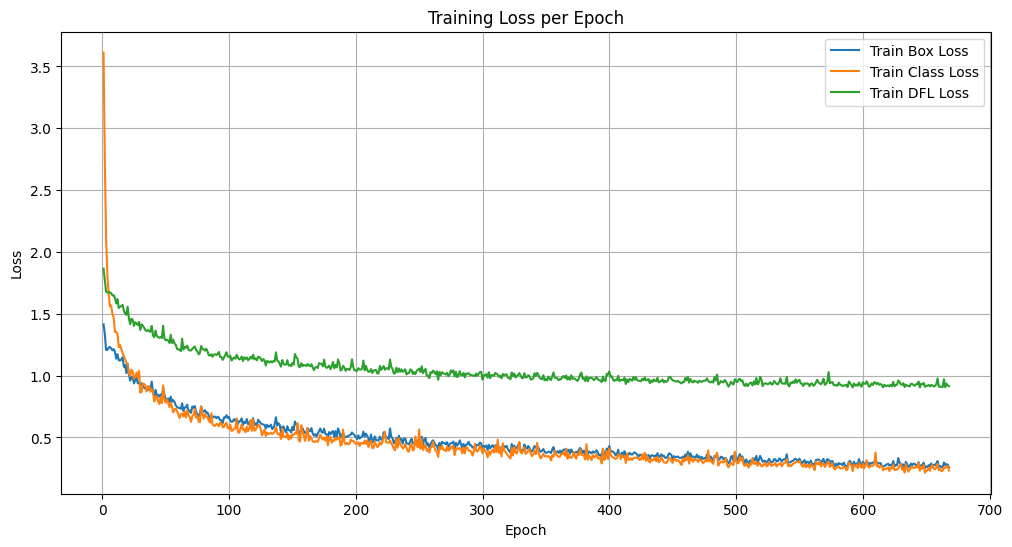

In [37]:
# Plot Losses
plt.figure(figsize=(12,6))
plt.plot(results_csv['epoch'], results_csv['train/box_loss'], label='Train Box Loss')
plt.plot(results_csv['epoch'], results_csv['train/cls_loss'], label='Train Class Loss')
plt.plot(results_csv['epoch'], results_csv['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

In [38]:
print(results_csv.columns)


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


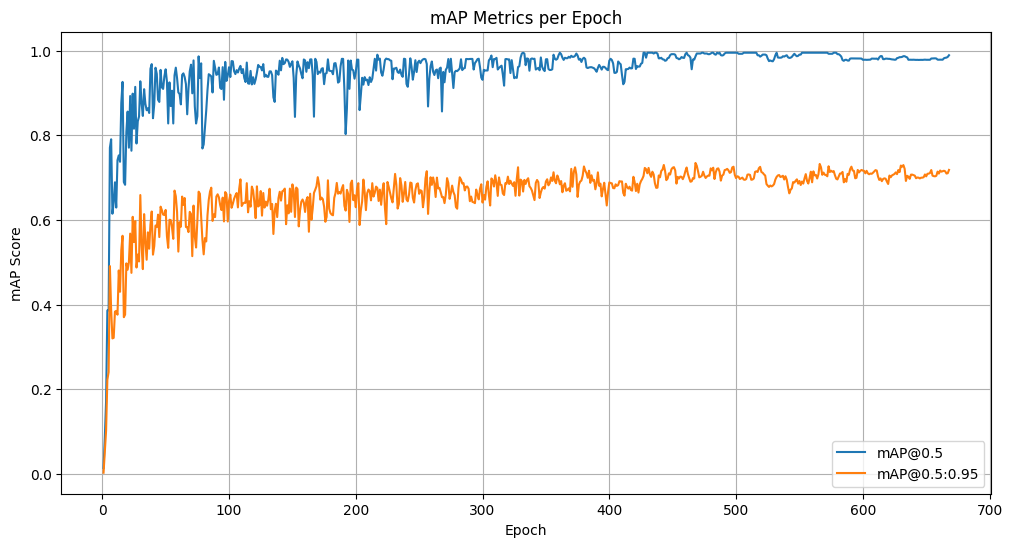

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(results_csv['epoch'], results_csv['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results_csv['epoch'], results_csv['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.title('mAP Metrics per Epoch')
plt.xlabel('Epoch')
plt.ylabel('mAP Score')
plt.legend()
plt.grid(True)
plt.show()

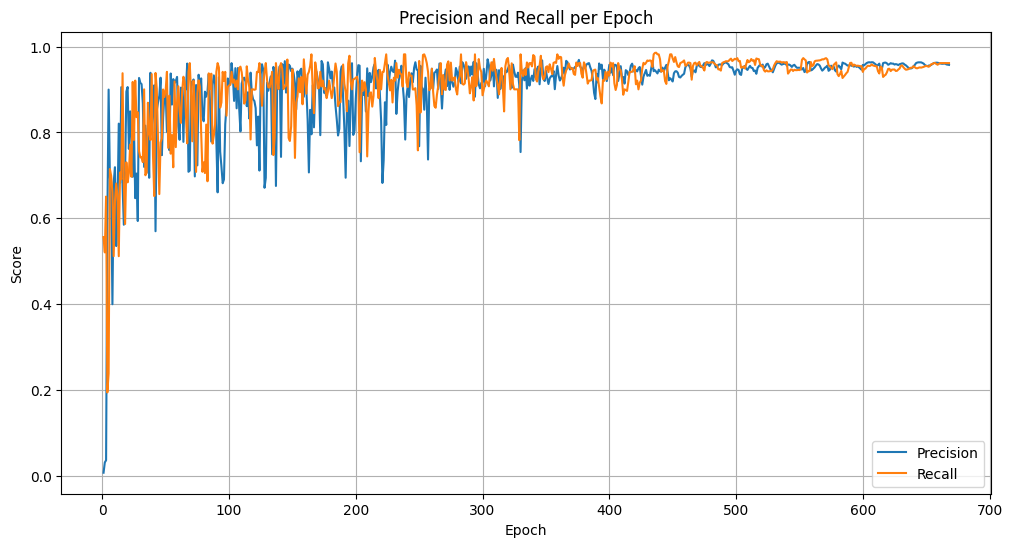

In [40]:
# Plot Precision and Recall
plt.figure(figsize=(12, 6))
plt.plot(results_csv['epoch'], results_csv['metrics/precision(B)'], label='Precision')
plt.plot(results_csv['epoch'], results_csv['metrics/recall(B)'], label='Recall')
plt.title('Precision and Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


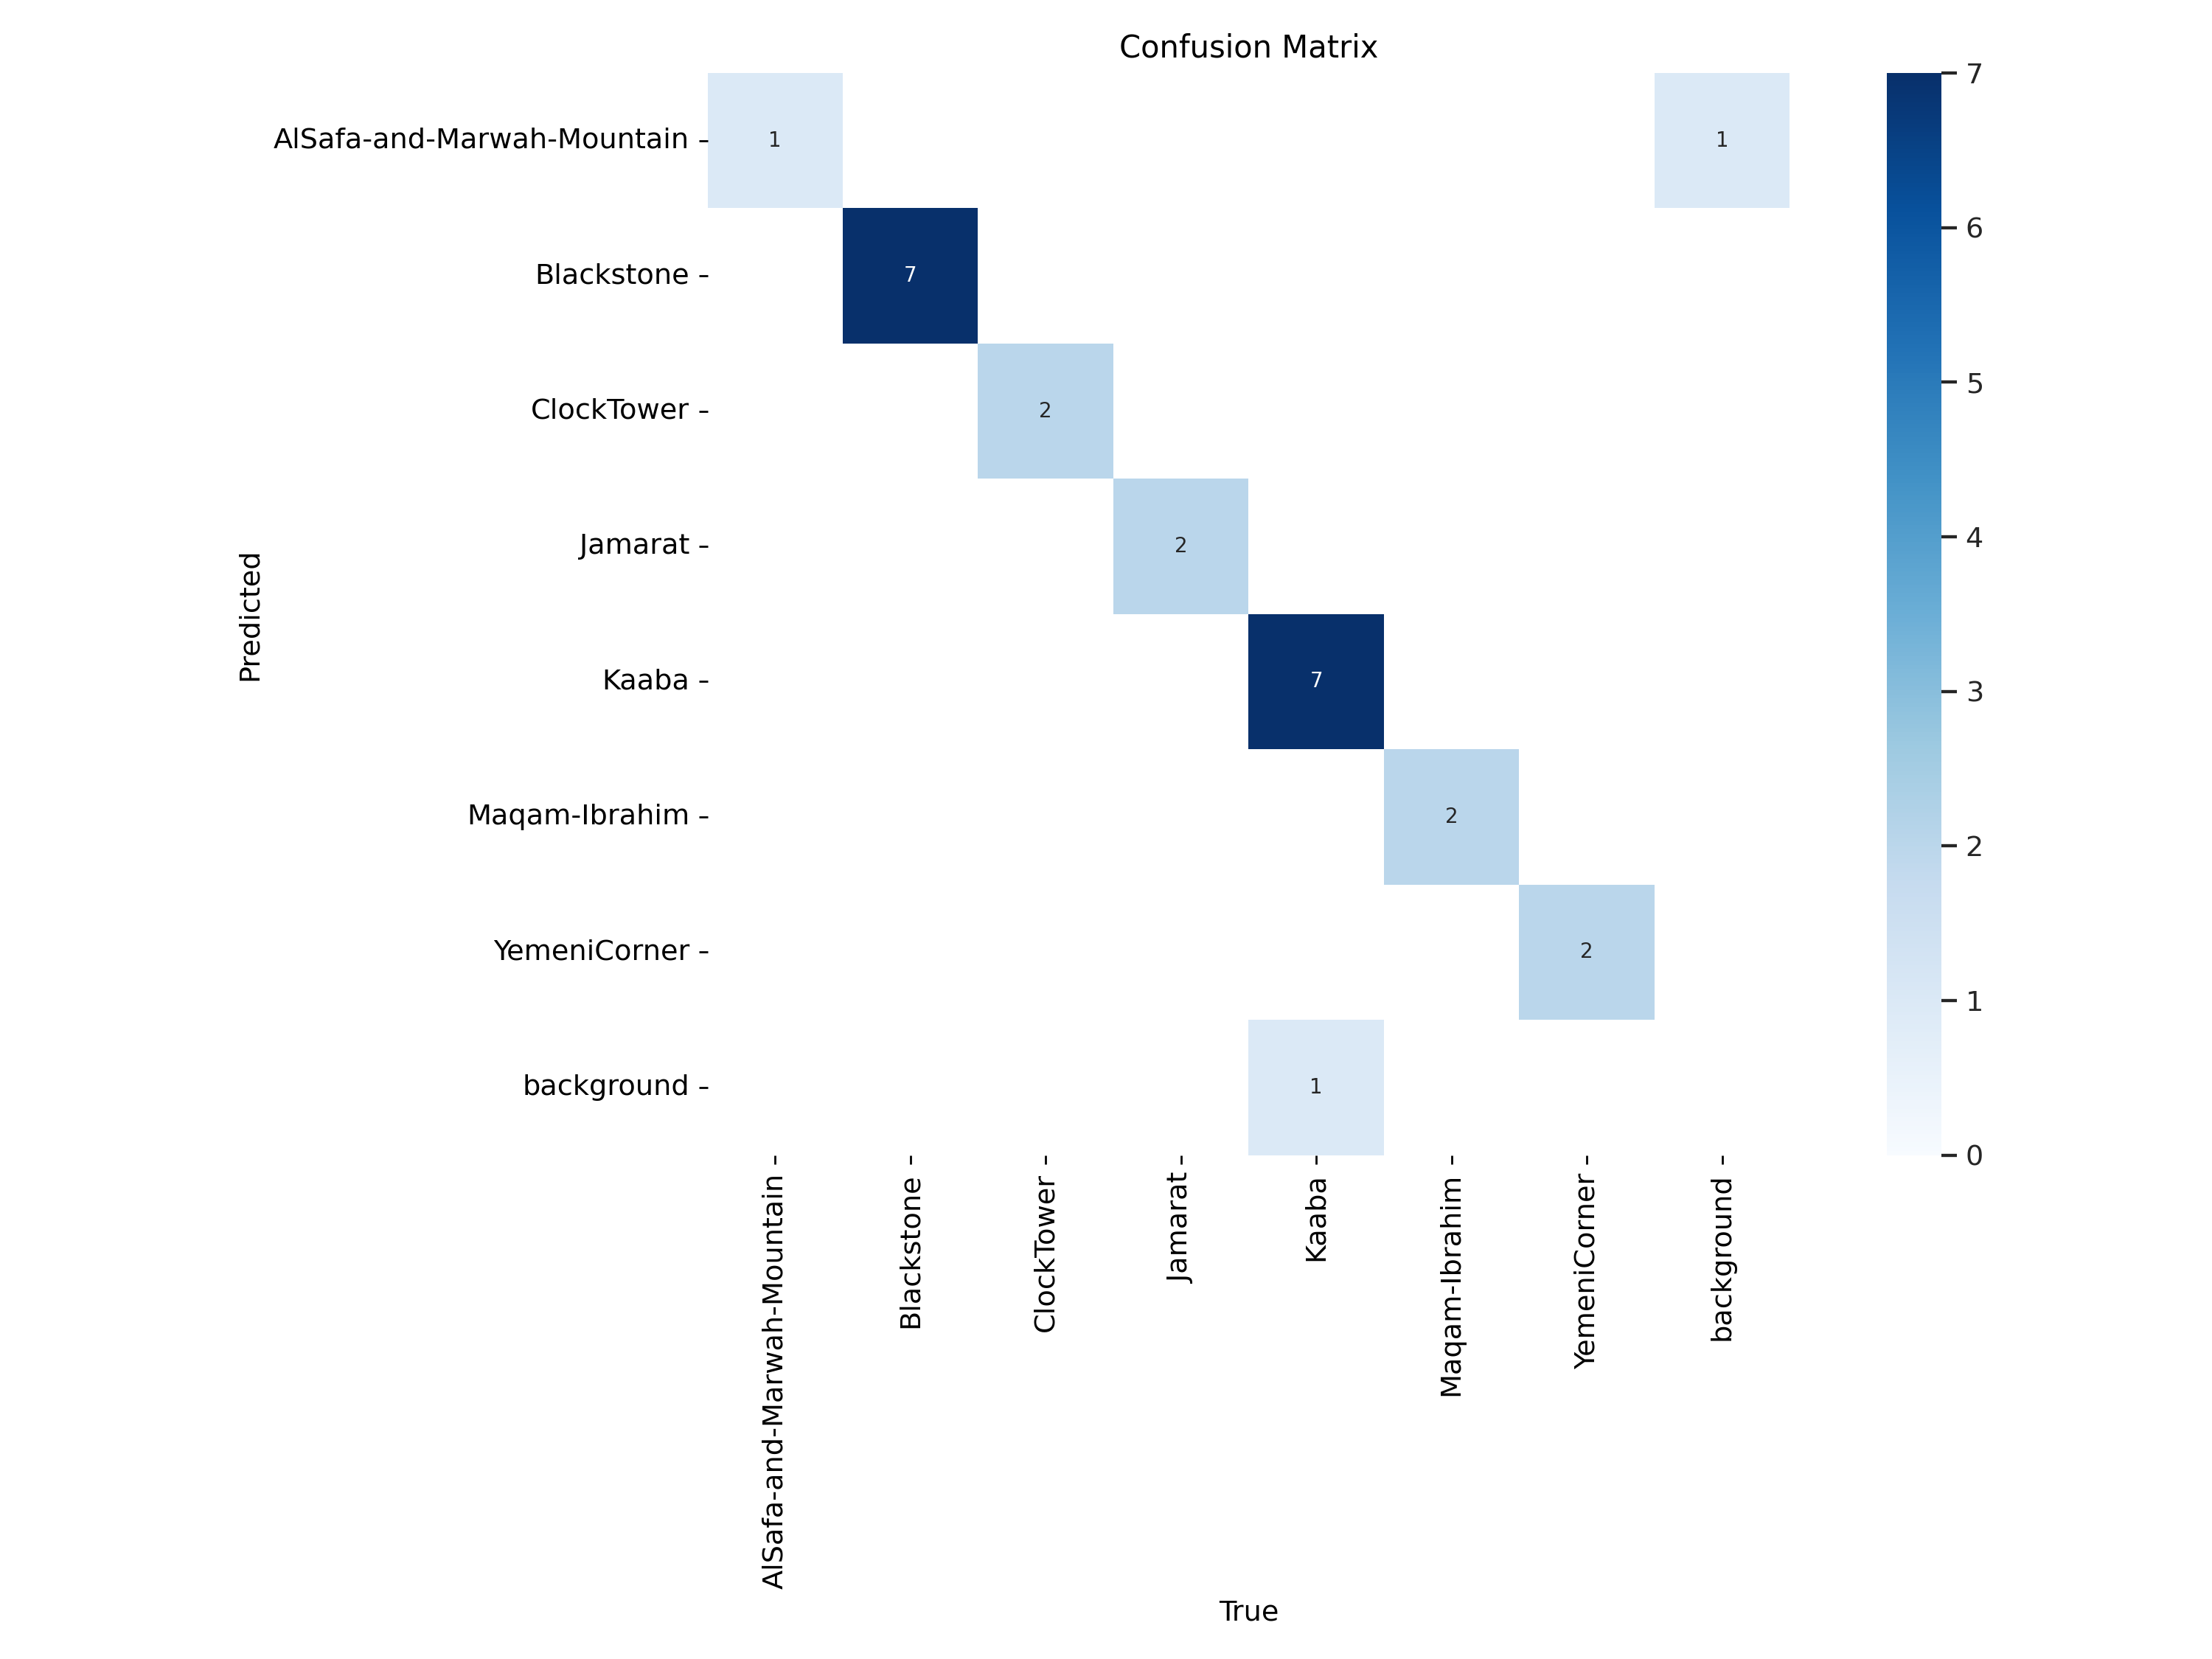

In [41]:
from IPython.display import Image, display
display(Image(filename='runs/detect/makkah-yolo/confusion_matrix.png'))

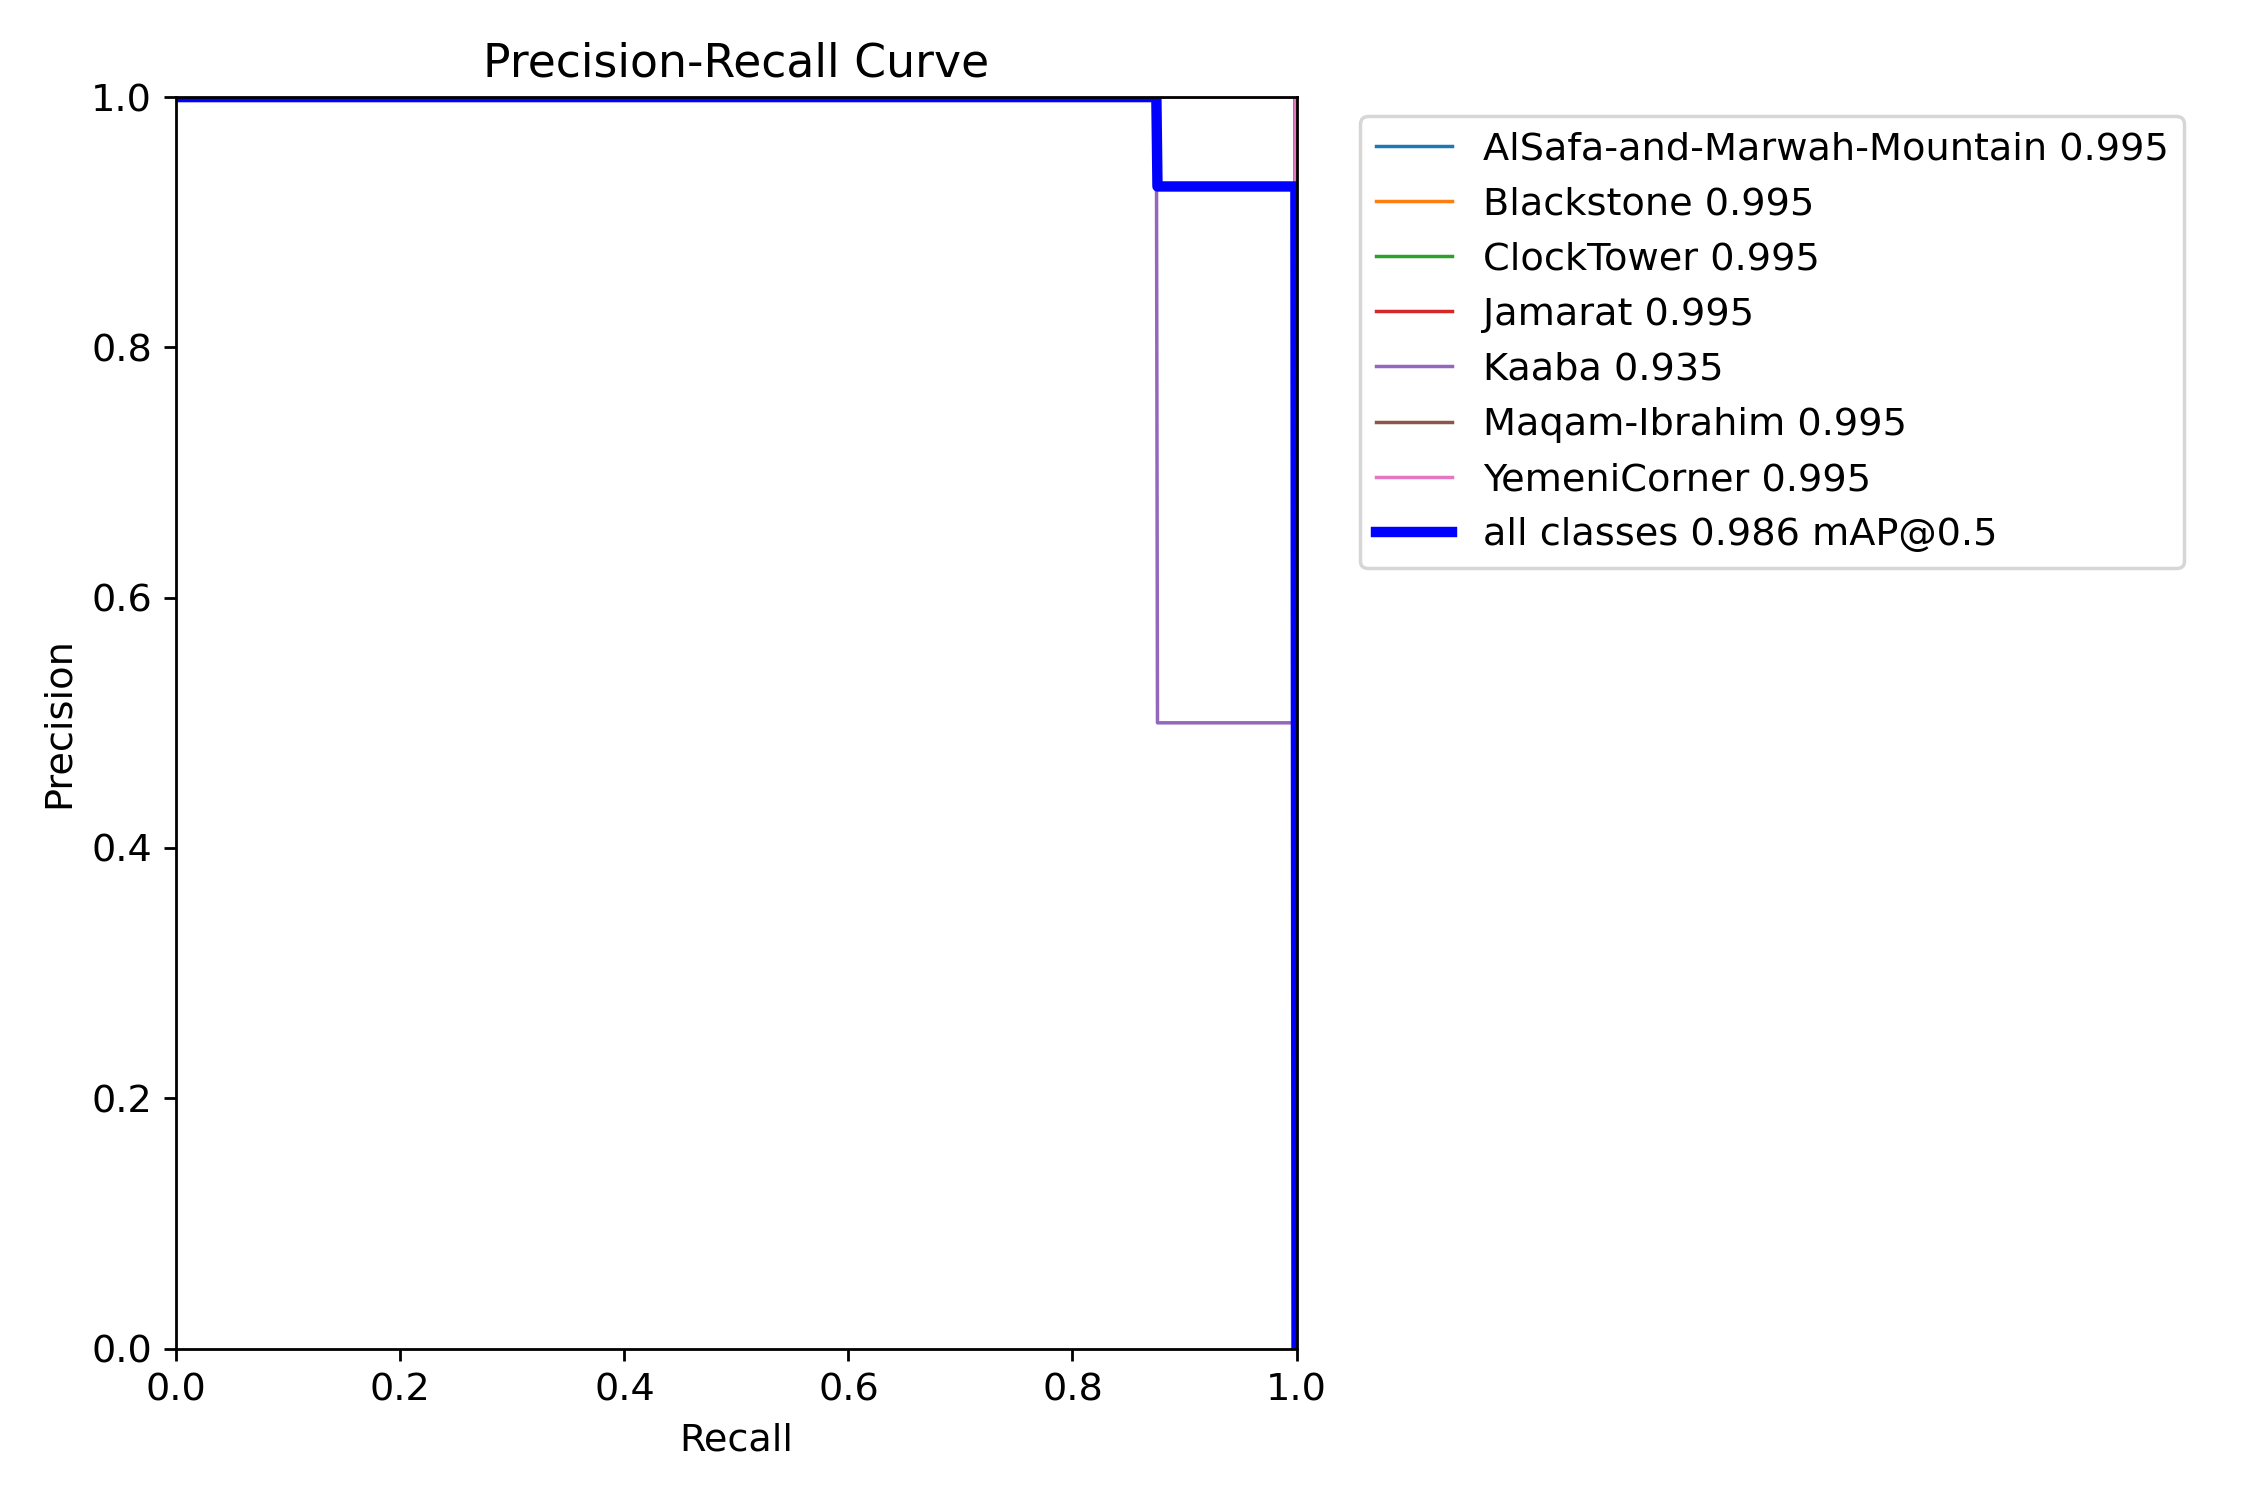

In [42]:
# Step 6: Precision-Recall Curves
display(Image(filename='runs/detect/makkah-yolo/PR_curve.png'))

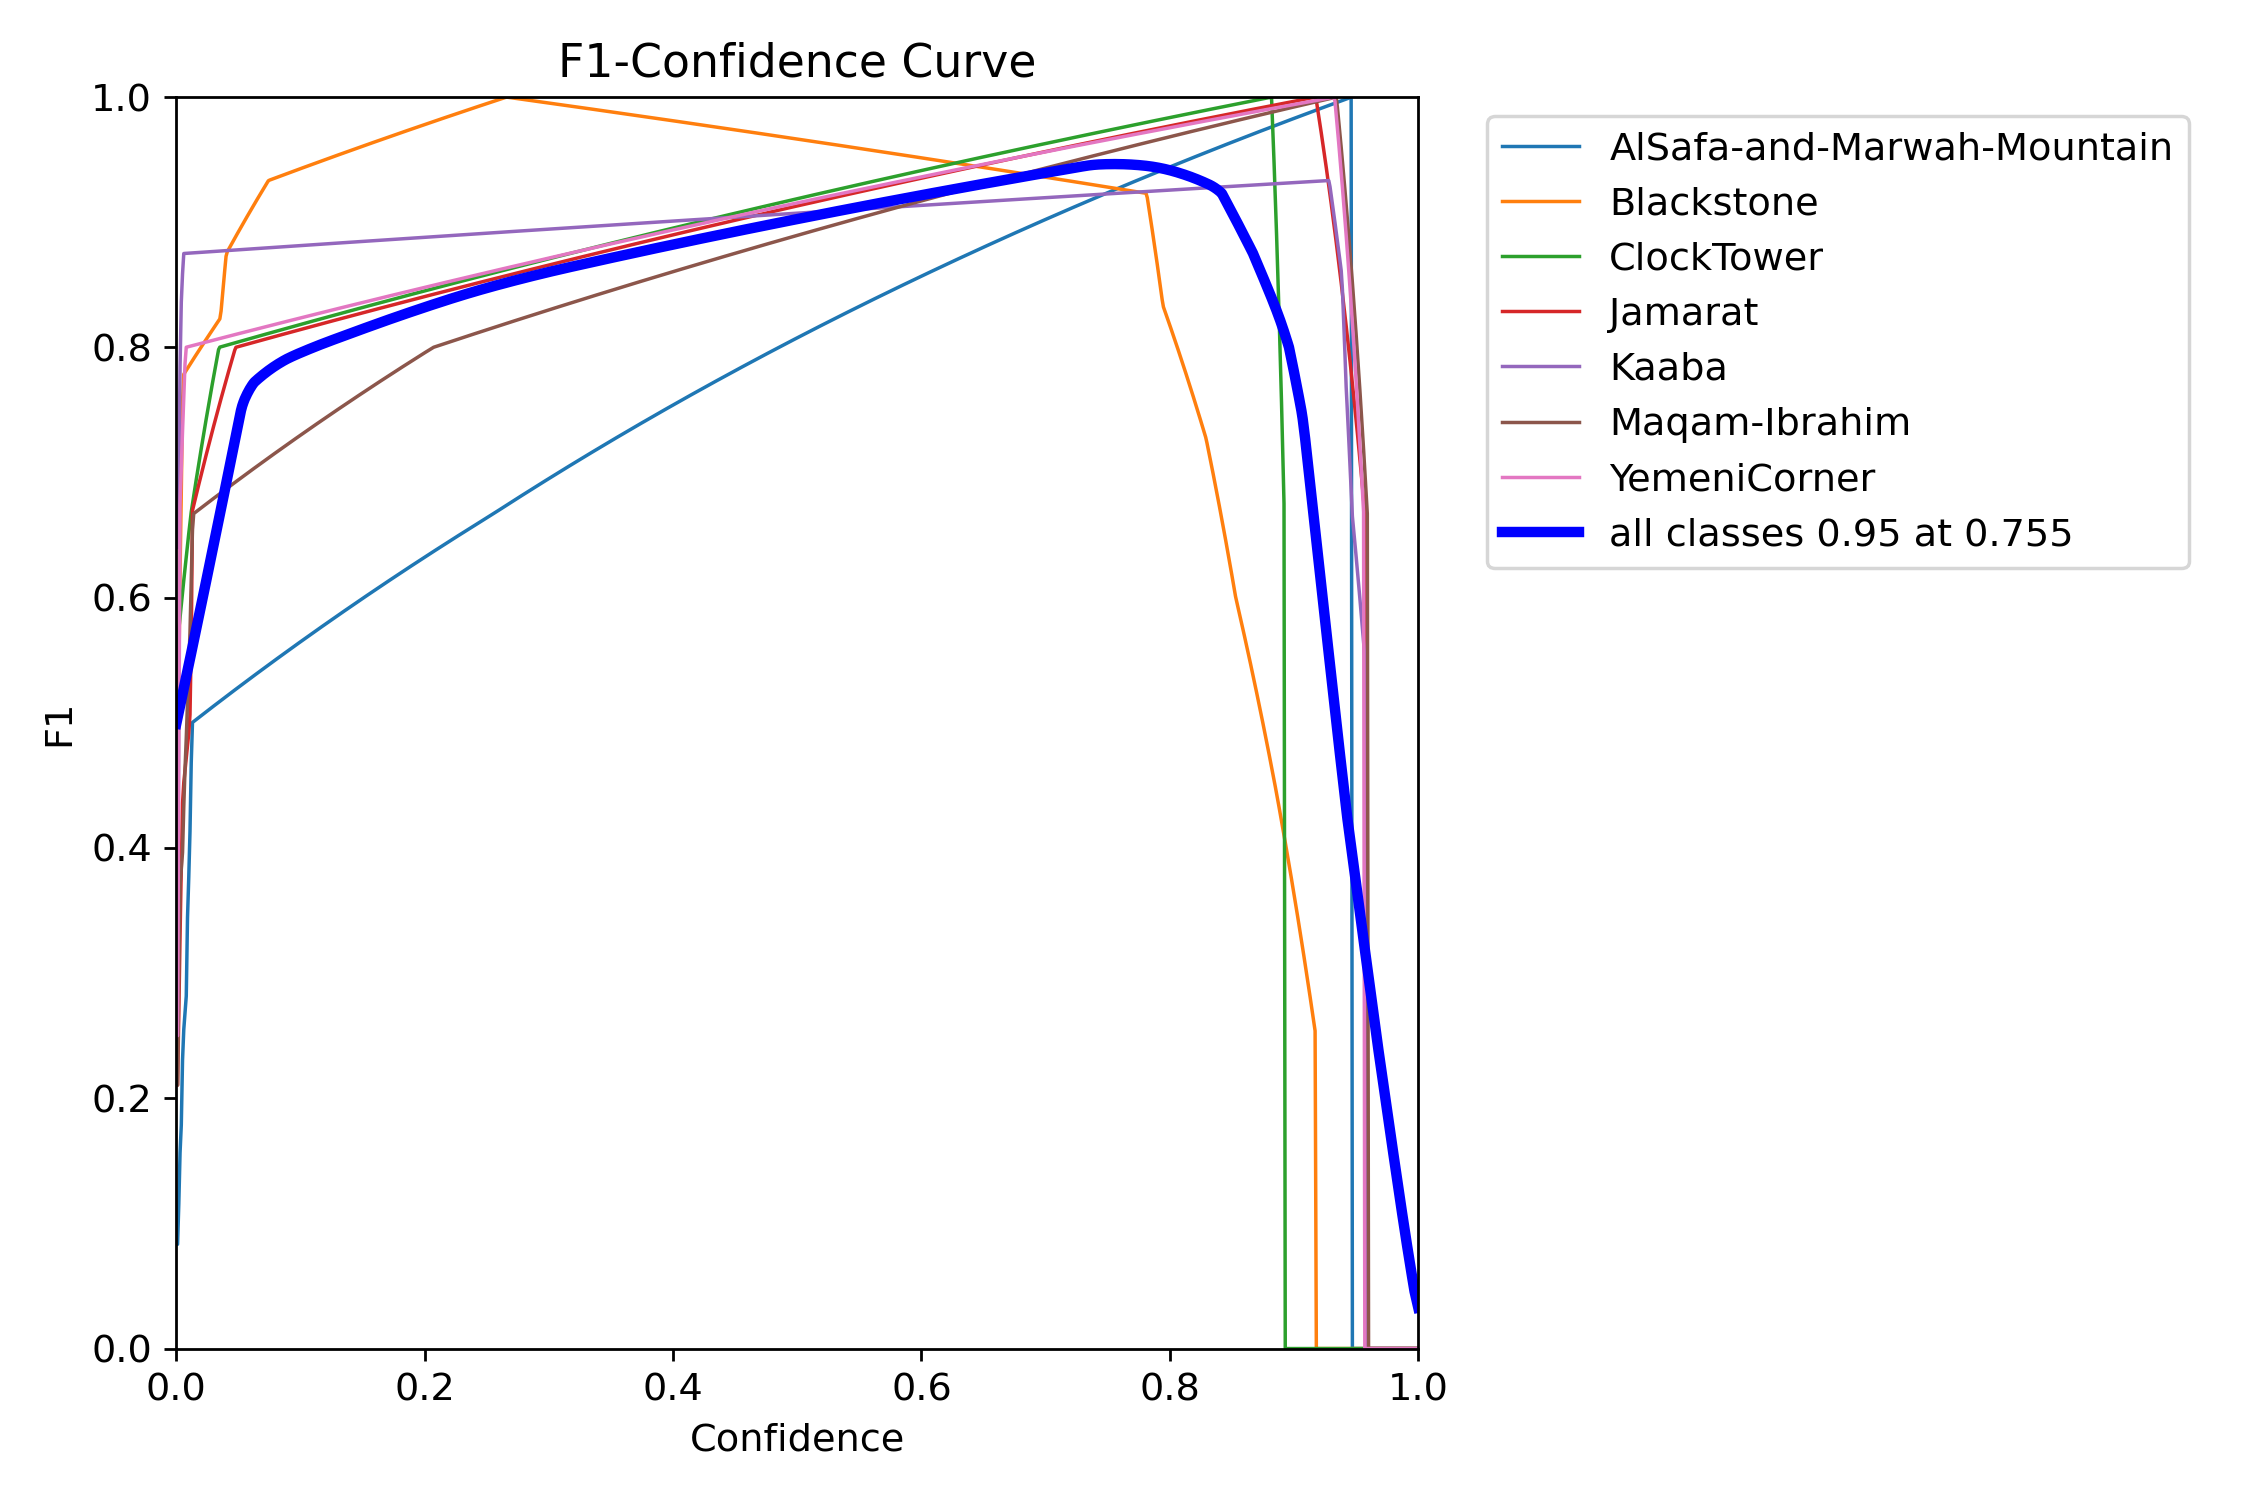

In [43]:
# Step 7: F1-Confidence Curve
display(Image(filename='runs/detect/makkah-yolo/F1_curve.png'))

# Inference

In [44]:

model = YOLO('runs/detect/makkah-yolo/weights/best.pt')


In [45]:
results = model.predict(
    source='/content/Makkah-Landmarkd-1/valid/images/11_jpg.rf.d19577db5e3e3c2af71a6081d50c9bad.jpg',
    conf=0.25,
    save=True,
    imgsz=640
)



image 1/1 /content/Makkah-Landmarkd-1/valid/images/11_jpg.rf.d19577db5e3e3c2af71a6081d50c9bad.jpg: 640x640 1 Kaaba, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


100%|██████████| 18.3M/18.3M [00:00<00:00, 280MB/s]



image 1/1 /content/Makkah-Landmarkd-1/valid/images/11_jpeg.rf.934d4294000b712f0e964236783790c9.jpg: 640x640 1 YemeniCorner, 15.6ms
Speed: 2.5ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


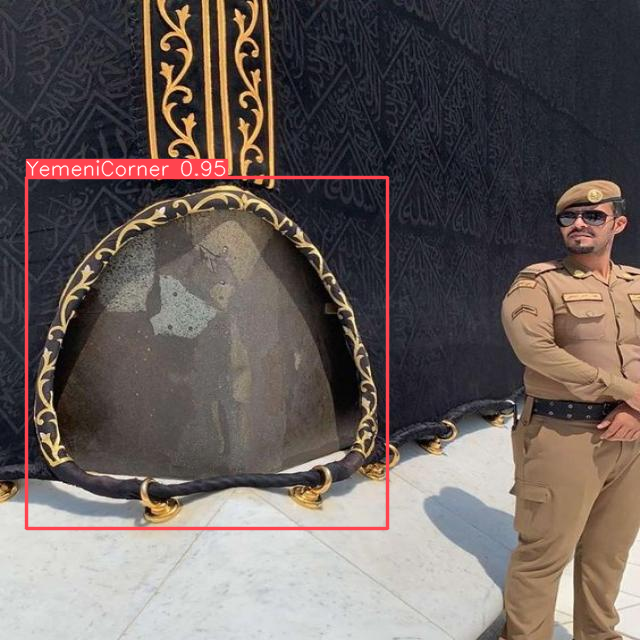

In [46]:
from ultralytics import YOLO


model = YOLO("https://huggingface.co/leyla95/makkah-yolo-model_A1/resolve/main/best.pt")

results = model("/content/Makkah-Landmarkd-1/valid/images/11_jpeg.rf.934d4294000b712f0e964236783790c9.jpg", conf=0.5)

results[0].show()

In [47]:
!pip uninstall bitsandbytes -y
!pip install git+https://github.com/TimDettmers/bitsandbytes.git

  Cloning https://github.com/TimDettmers/bitsandbytes.git to /tmp/pip-req-build-0cdgugsn
  Running command git clone --filter=blob:none --quiet https://github.com/TimDettmers/bitsandbytes.git /tmp/pip-req-build-0cdgugsn
  Resolved https://github.com/TimDettmers/bitsandbytes.git to commit 49c044b1daa22f17af6907ad26ae604758d55e1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bitsandbytes: filename=bitsandbytes-0.46.0.dev0-cp311-cp311-linux_x86_64.whl size=93503 sha256=2573b4cd71933edd594a1b0beb124af2e91ae87abad5fc19c6c36e9f8756f264
  Stored in directory: /tmp/pip-ephem-wheel-cache-xoi8ab2i/wheels/85/06/31/de7992855a6f6df8812a233c904db938c7a990eb338eadb41a
Successfully built bitsandbytes


In [48]:
import bitsandbytes as bnb
print(bnb.__version__)


ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: cannot open shared object file: No such file or directory
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 87, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 74, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: cannot op

0.46.0.dev0


In [49]:
from PIL import Image
from ultralytics import YOLO
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import gc
import re


from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained(
    "ALLaM-AI/ALLaM-7B-Instruct-preview",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(
    "ALLaM-AI/ALLaM-7B-Instruct-preview",
    trust_remote_code=True
)

landmark_info = {
    "AlSafa-and-Marwah-Mountain": {
        "name_ar": "السعي بين الصفا والمروة",
        "description": "المسافة التي يسعى فيها الحاج بين جبلي الصفا والمروة أثناء الحج والعمرة، وهي شعيرة مهمة من مناسك الإسلام."
    },
    "Blackstone": {
        "name_ar": "الحجر الأسود",
        "description": "الحجر الأسود هو حجر مقدس مثبت في أحد أركان الكعبة المشرفة، يُستحب للمسلمين تقبيله أو الإشارة إليه أثناء الطواف."
    },
    "ClockTower": {
        "name_ar": "برج الساعة",
        "description": "برج الساعة في مكة المكرمة، أحد أطول المباني في العالم، يقع ضمن مجمع أبراج البيت ويطل على المسجد الحرام."
    },
    "Jamarat": {
        "name_ar": "الجمرات",
        "description": "مواقع شعائرية في منى بمكة المكرمة، حيث يرمي الحجاج الجمرات الثلاث كجزء من مناسك الحج."
    },
    "Kaaba": {
        "name_ar": "الكعبة المشرفة",
        "description": "أقدس بيت لله في الإسلام، يتوجه المسلمون إليه في صلاتهم، ويؤدون الطواف حوله خلال الحج والعمرة."
    },
    "MaqamIbrahim": {
        "name_ar": "مقام إبراهيم",
        "description": "حجر أثري يقع بجوار الكعبة المشرفة، يُعتقد أن النبي إبراهيم عليه السلام وقف عليه أثناء بناء الكعبة."
    },
    "YemeniCorner": {
        "name_ar": "الركن اليماني",
        "description": "الركن الجنوبي الغربي للكعبة المشرفة، يُستحب استلامه باليد أثناء الطواف دون تقبيل."
    }
}



config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

In [50]:
from ultralytics import YOLO

yolo_model = YOLO("https://huggingface.co/leyla95/makkah-yolo-model/resolve/main/best.pt")


Found https://huggingface.co/leyla95/makkah-yolo-model/resolve/main/best.pt locally at weights/best.pt


In [51]:
image_path = "/content/Makkah-Landmarkd-1/valid/images/11_jpeg.rf.934d4294000b712f0e964236783790c9.jpg"
results = yolo_model.predict(image_path, conf=0.25)
detections = results[0].names
boxes = results[0].boxes.cls
detected_classes = [detections[int(cls_id)] for cls_id in boxes]

del results
gc.collect()
torch.cuda.empty_cache()

for detected_class in detected_classes:
    if detected_class in landmark_info:
        name_ar = landmark_info[detected_class]["name_ar"]
        description = landmark_info[detected_class]["description"]
        user_prompt = f"تحدث عن {name_ar} في مكة المكرمة، ووضح أهميته الدينية والتاريخية.\nمعلومات أساسية: {description}"
    else:
        user_prompt = f"تحدث عن {detected_class} في مكة المكرمة."

    print("\n🧾 Arabic Prompt:")
    print(user_prompt)

    messages = [{"role": "user", "content": user_prompt}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=False)
    inputs = tokenizer(inputs, return_tensors='pt', return_token_type_ids=False)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    response = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.6
    )

    output_text = tokenizer.batch_decode(response, skip_special_tokens=True)[0]
    output_text = re.sub(r'\[INST\](.*?)\[/INST\]', '', output_text, flags=re.DOTALL).strip()

    print("\n🕌 Arabic Cultural Explanation:")
    print(output_text)



image 1/1 /content/Makkah-Landmarkd-1/valid/images/11_jpeg.rf.934d4294000b712f0e964236783790c9.jpg: 640x640 1 YemeniCorner, 15.6ms
Speed: 4.8ms preprocess, 15.6ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 640)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🧾 Arabic Prompt:
تحدث عن الركن اليماني في مكة المكرمة، ووضح أهميته الدينية والتاريخية.
معلومات أساسية: الركن الجنوبي الغربي للكعبة المشرفة، يُستحب استلامه باليد أثناء الطواف دون تقبيل.

🕌 Arabic Cultural Explanation:
الركن اليماني هو أحد أركان الكعبة المشرفة الأربعة ويقع في الجنوب الغربي للكعبة، ويعتبر من المعالم الإسلامية البارزة في مكة المكرمة. يُستحب للمسلمين استلام الركن اليماني باليد اليمنى دون تقبيل أثناء الطواف حول الكعبة، وذلك اتباعًا للسنة النبوية.

من الناحية الدينية، يُعتبر الركن اليماني من الأركان التي تحمل بركة الكعبة، وهو يُعتبر من المواطن التي يُستجاب فيها الدعاء، حيث قال النبي محمد صلى الله عليه وسلم: "إن مسح الحجر الأسود والركن اليماني يحطان الخطايا حطًّا".

تاريخيًا، يعود بناء الركن اليماني إلى عهد النبي إبراهيم وابنه إسماعيل عليهما السلام، حيث كان الركن جزءًا من بناء الكعبة المشرفة.
